# Introduction: Forecasting of Attraction Wait Times using Time series analysis with lagging function


###### Components of a Time-Series
###### Trend - The trend shows a general direction of the time series data over a long period of time. A  trend can be increasing(upward), decreasing(downward), or horizontal(stationary).
###### Seasonality - The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions.
###### Cyclical Component - These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.
###### Irregular Variation - These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.
###### ETS Decomposition - ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend and Seasonality.

## SETUP: IMPORT LIBRARIES


In [220]:
import sys
import os
import re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,median_absolute_error,mean_absolute_percentage_error

# Configure visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
warnings.filterwarnings('ignore')

In [128]:
# from google.colab import drive
# drive.mount('/content/drive')

## Get the Data

### Solution for compiling waiting times data for 15 attractions for past 3 years.

In [ ]:
# Folder with the Excel files
folder_path = 'EU_Park/europark_raw_files/'

# Regex to extract attraction, month, and year from filename
pattern = r'^(.*?) - Queue times in (\w+) (\d{4})\.xlsx'

# Dictionary to hold data for each attraction
attraction_data = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        match = re.match(pattern, filename)
        if match:
            attraction = match.group(1).strip()
            month = match.group(2)
            year = int(match.group(3))
            file_path = os.path.join(folder_path, filename)

            # Read the file
            df = pd.read_excel(file_path)

            # Add metadata
            df['Month'] = month
            df['Year'] = year

            # Rename columns for consistency
            df.columns = ['Datetime', 'WaitTime', 'Month', 'Year']

            # Add to the attraction's list
            if attraction not in attraction_data:
                attraction_data[attraction] = []
            attraction_data[attraction].append(df)

# For each attraction, combine all months and save one Excel file
safe_attraction_name_list = []
save_path = 'EU_Park/europark_attraction_merged_dfs/'
for attraction, dfs in attraction_data.items():
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop rows where Datetime is missing
    combined_df = combined_df.dropna(subset=['Datetime'])

    # Split Datetime into Date and Time using string operations
    combined_df[['Date', 'Time']] = combined_df['Datetime'].astype(str).str.strip().str.split(' ', expand=True)
    safe_attraction_name = attraction.replace('-', ' ')  # avoid file path issues # Create the output file path
    fil_safe_attraction_name = safe_attraction_name.replace(' ','_')
    safe_attraction_name_list.append(fil_safe_attraction_name)
    # print(safe_attraction_name_list)
    output_file = os.path.join(save_path, f"{fil_safe_attraction_name} - All Queue Times.xlsx")
    combined_df.to_excel(output_file, index=False)
    print(f"✅ Saved merged file for: {attraction} -> {output_file}")

#### Merge All attractions in one single excel file

In [ ]:
# Folder where individual attraction Excel files are stored
folder_path = 'EU_Park/europark_attraction_merged_dfs/'

# Get list of merged attraction files
files = [f for f in os.listdir(folder_path) if f.endswith('All Queue Times.xlsx')]
print(files)

In [ ]:
merged_df = None

for file in files:
    # Full path to the Excel file
    file_path = os.path.join(folder_path, file)

    # Extract attraction name from filename
    attraction = file.replace(' - All Queue Times.xlsx', '').strip()

    # Read file
    df = pd.read_excel(file_path)
    df = df.drop(columns=['Datetime'], errors='ignore')
    df.rename(columns={'WaitTime': f'{attraction}_WaitTime'}, inplace=True)

    # Merge using pandas only
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on=['Date', 'Time', 'Month', 'Year'], how='outer')

merged_df = merged_df.sort_values(by=['Date', 'Time'])

output_file = os.path.join(folder_path, 'All_Attractions_Queue_Times_By_Date_Time.csv')
merged_df.to_csv(output_file, index=False)

print(f"✅ Final merged file saved to: {output_file}")

In [ ]:
merged_df_dt = pd.read_csv("EU_PARK\europark_attraction_merged_dfs\All_Attractions_Queue_Times_By_Date_Time.csv",index_col=False)

In [ ]:
merged_df_dt.dropna()

In [ ]:
merged_df_dt.info()

In [ ]:
merged_df_dt.isna().sum()

In [ ]:
def report_missing_values(df):
    total_rows = len(df)
    missing_count = df.isna().sum()
    missing_percent = (missing_count / total_rows) * 100

    result = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent.round(2)
    })
    result = result.sort_values(by='Missing %', ascending=False)

    print(result)  # Only show columns with missing values

report_missing_values(merged_df_dt)

#### Function to merge weather dataset


In [ ]:
def merge_fn_wind_prec_temp(df_path,df_type):
    """
    Parameters:
        df_path (str): Path to folder containing Excel files.
        data_type (str): Type of data ('wind', 'prec', 'temp', etc.)
        
    Returns:
        pd.DataFrame: Combined dataframe with Month and Year columns.
    """
    files = [f for f in os.listdir(df_path) if f.endswith('.xlsx')]
    data_final = []
    for file in files:
        file_path = os.path.join(df_path, file)

        # Extract month and year from filename: 'Wind speed in March 2024.xlsx'
        if df_type == 'wind':
            name_parts = file.replace('.xlsx', '').replace('Wind speed in ', '').strip().split()
        elif df_type == 'prec':
            name_parts = file.replace('.xlsx', '').replace('Precipitation probability in ', '').strip().split()
        elif df_type == 'temp':
            name_parts = file.replace('.xlsx', '').replace('Temperatures in ', '').strip().split()
        else:
            raise ValueError(f"Unknown data_type: {df_type}")
        month = name_parts[0]
        year = name_parts[1]

        # Read the file
        df = pd.read_excel(file_path)

        # Add Month and Year columns
        df['Month'] = month
        df['Year'] = int(year)
        data_final.append(df)

    # Combine all dataframes into one
    wind_df = pd.concat(data_final, ignore_index=True)
    wind_df[['Date', 'Time']] = wind_df['date_time'].astype(str).str.strip().str.split(' ', expand=True)
    wind_df = wind_df.drop(columns=['date_time'])

    return wind_df


In [ ]:
wind_loc = 'EU_PARK/wind_speed/'
final_wind_df = merge_fn_wind_prec_temp(wind_loc,df_type='wind')

In [ ]:
precipitation_loc = 'EU_PARK/precipitation/'
final_prec_df = merge_fn_wind_prec_temp(precipitation_loc,df_type='prec')


In [ ]:
temperature_loc = 'EU_PARK/temperatures/'
final_temp_df = merge_fn_wind_prec_temp(temperature_loc,df_type='temp')


In [ ]:
merge_keys = ['Month', 'Year', 'Date', 'Time']
# Step-by-step outer merges using pandas only
merged = pd.merge(merged_df_dt, final_temp_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_prec_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_wind_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')

# Optional: sort for clean structure
final_merged = merged.sort_values(by=['Year', 'Month', 'Date', 'Time']).reset_index(drop=True)




In [ ]:
report_missing_values(final_merged)

### Loading the Merged dataframe for Arthur for our ML Project

In [129]:
# df = pd.read_csv('/content/drive/MyDrive/ARTHUR_Queue_Times_By_Date_Time.csv')
df = pd.read_csv('ARTHUR_Queue_Times_By_Date_Time.csv')

print("Dataset 'ARTHUR_Queue_Times_By_Date_Time.csv' loaded successfully.")

Dataset 'ARTHUR_Queue_Times_By_Date_Time.csv' loaded successfully.


In [130]:
df.head()

,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh
0,0,-4.0,April,2022,2022-04-01,08:15,NaN,NaN,NaN
1,1,-4.0,April,2022,2022-04-01,08:20,NaN,NaN,NaN
2,2,-4.0,April,2022,2022-04-01,08:25,NaN,NaN,NaN
3,3,-4.0,April,2022,2022-04-01,08:30,NaN,NaN,NaN
4,4,-4.0,April,2022,2022-04-01,08:35,NaN,NaN,NaN


In [131]:
df.isna().sum()

Unnamed: 0                      0
ARTHUR_WaitTime              2336
Month                           0
Year                            0
Date                            0
Time                          836
temperature_in_celsius      85828
precipitation_in_percent    85828
wind_speed_in_kmh           85828
dtype: int64

In [132]:
df.describe()

,Unnamed: 0,ARTHUR_WaitTime,Year,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh
count,549604.000000,547268.000000,549604.000000,463776.000000,463776.000000,463776.000000
mean,274801.500000,24.365812,2023.231501,15.718453,26.695064,13.889572
std,158657.153011,15.866329,0.888536,7.772595,19.392560,11.390221
min,0.000000,-4.000000,2022.000000,-8.100000,0.000000,5.000000
25%,137400.750000,15.000000,2023.000000,10.200000,10.000000,5.000000
50%,274801.500000,25.000000,2023.000000,15.600000,30.000000,10.000000
75%,412202.250000,35.000000,2024.000000,21.600000,30.000000,15.000000
max,549603.000000,91.000000,2025.000000,36.300000,95.000000,70.000000


## Data Understanding and Cleaning

In [133]:
# Combine 'Date' and 'Time' into a single, proper datetime object for time series analysis.
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
# Sort the DataFrame chronologically to ensure the integrity of time-based operations.
df = df.sort_values(by='DateTime')

# Define the primary target variable for our analysis.
TARGET = 'ARTHUR_WaitTime'

In [134]:
# Drop redundant index columns that might exist from previous saves.
cols_to_drop = [col for col in df.columns if 'Unnamed: 0' in col]
df = df.drop(columns=cols_to_drop)

In [135]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print("\nStandardized Column Names:")
print(df.columns)


Standardized Column Names:
Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime'],
      dtype='object')


In [136]:
DATE_COL = 'datetime'
QUEUE_TIME_COL = 'arthur_waittime'
print(df.isnull().sum())

arthur_waittime              2336
month                           0
year                            0
date                            0
time                          836
temperature_in_celsius      85828
precipitation_in_percent    85828
wind_speed_in_kmh           85828
datetime                      836
dtype: int64


In [137]:
# Drop rows where the date or queue time is missing, as they are essential for analysis
df.dropna(subset=[DATE_COL, QUEUE_TIME_COL], inplace=True)
print(df.isnull().sum())



arthur_waittime                 0
month                           0
year                            0
date                            0
time                            0
temperature_in_celsius      84992
precipitation_in_percent    84992
wind_speed_in_kmh           84992
datetime                        0
dtype: int64


In [138]:
# Handling Duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicate rows removed. Current shape: {df.shape}")


Number of duplicate rows: 36
Duplicate rows removed. Current shape: (547232, 9)


In [139]:
# Creating features from waiting time columns according to available legends on source
df['status_open'] = (df['arthur_waittime'] == 0).astype(int)
df['status_virtual_queue'] = (df['arthur_waittime'] == -1).astype(int)
df['status_maintenance'] = (df['arthur_waittime'] == -2).astype(int)
df['status_closed_weather'] = (df['arthur_waittime'] == -3).astype(int)
df['status_attraction_closed'] = (df['arthur_waittime'] == -4).astype(int)
df['status_over_90_min'] = (df['arthur_waittime'] == 91).astype(int)

In [140]:
TARGET = 'arthur_waittime'
df.loc[df[TARGET] < 0, TARGET] = np.nan

In [141]:
# Impute missing values using forward-fill followed by backward-fill.
# This ensures that gaps are filled with the most recent valid observation, which is a
# reasonable assumption for slowly changing data like weather and wait times.

# print("Imputing missing values for target and weather features...")
# df[TARGET] = df[TARGET].ffill().bfill()
# weather_features = ['temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh']
# df[weather_features] = df[weather_features].ffill().bfill()

In [142]:
print(df.isnull().sum())

arthur_waittime             52699
month                           0
year                            0
date                            0
time                            0
temperature_in_celsius      84971
precipitation_in_percent    84971
wind_speed_in_kmh           84971
datetime                        0
status_open                     0
status_virtual_queue            0
status_maintenance              0
status_closed_weather           0
status_attraction_closed        0
status_over_90_min              0
dtype: int64


In [143]:
df = df.dropna()

In [144]:
# Extract useful features from the datetime column
df['year'] = df[DATE_COL].dt.year
df['month'] = df[DATE_COL].dt.month_name()
df['day'] = df[DATE_COL].dt.day
df['hour'] = df[DATE_COL].dt.hour
df['day_of_week'] = df[DATE_COL].dt.day_name()
df['week_of_year'] = df[DATE_COL].dt.isocalendar().week.astype(int)
df['is_weekend'] = df[DATE_COL].dt.dayofweek.isin([5, 6]).astype(int) # 5: Saturday, 6: Sunday

print("New time-based features created:")
print(df[['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend']].head())

New time-based features created:
       year    month  day  hour day_of_week  is_weekend
99724  2022  October   11     9     Tuesday           0
99725  2022  October   11     9     Tuesday           0
99726  2022  October   11     9     Tuesday           0
99727  2022  October   11     9     Tuesday           0
99728  2022  October   11     9     Tuesday           0


## Exploratory Data Analysis

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418322 entries, 99724 to 534634
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   arthur_waittime           418322 non-null  float64       
 1   month                     418322 non-null  object        
 2   year                      418322 non-null  int64         
 3   date                      418322 non-null  object        
 4   time                      418322 non-null  object        
 5   temperature_in_celsius    418322 non-null  float64       
 6   precipitation_in_percent  418322 non-null  float64       
 7   wind_speed_in_kmh         418322 non-null  float64       
 8   datetime                  418322 non-null  datetime64[ns]
 9   status_open               418322 non-null  int32         
 10  status_virtual_queue      418322 non-null  int32         
 11  status_maintenance        418322 non-null  int32         
 12

In [146]:
# DESCRIPTIVE STATISTICS

print(f"\nDescriptive statistics for '{QUEUE_TIME_COL}':")
print(df[QUEUE_TIME_COL].describe())


Descriptive statistics for 'arthur_waittime':
count    418322.000000
mean         26.809747
std          13.906636
min           0.000000
25%          20.000000
50%          25.000000
75%          35.000000
max          91.000000
Name: arthur_waittime, dtype: float64


### Univariant analysis of attraction

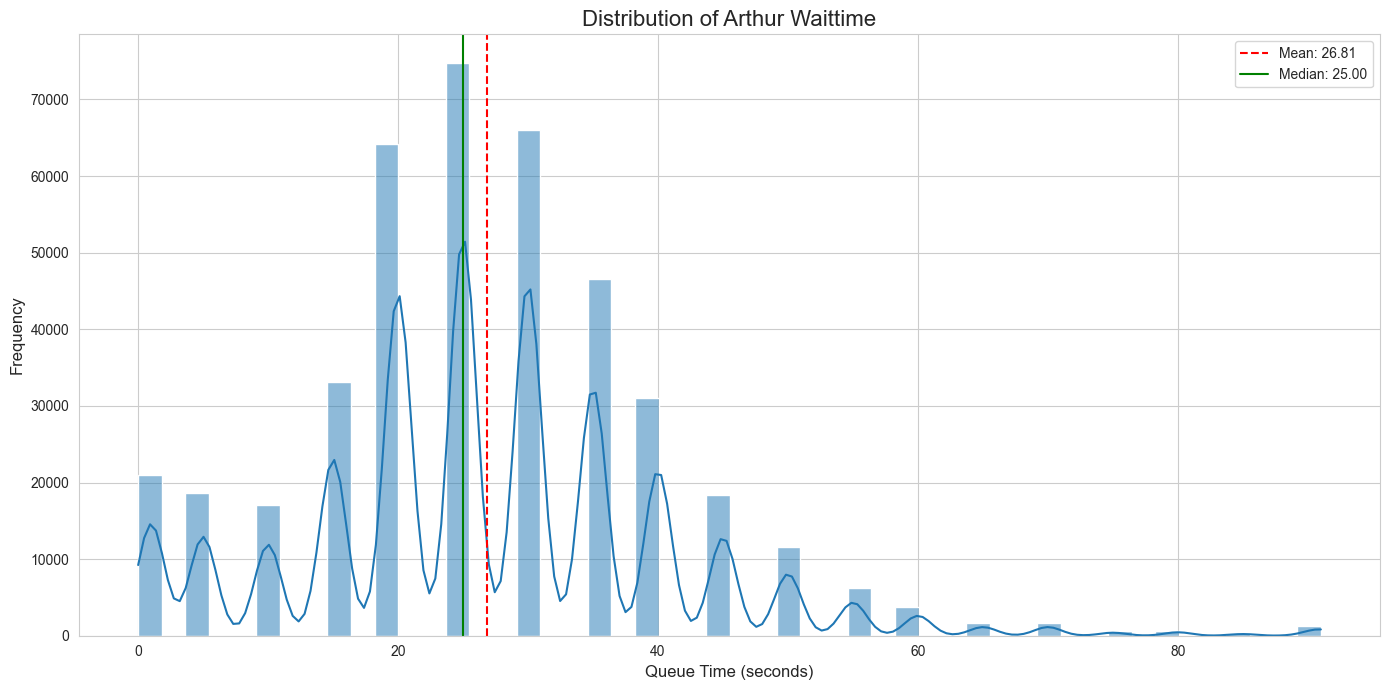

In [ ]:
# Distribution of Queue Times
plt.figure(figsize=(14, 7))
sns.histplot(df[QUEUE_TIME_COL], kde=True, bins=50)
plt.title(f'Distribution of {QUEUE_TIME_COL.replace("_", " ").title()}', fontsize=16)
plt.xlabel('Queue Time (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df[QUEUE_TIME_COL].mean(), color='red', linestyle='--', label=f'Mean: {df[QUEUE_TIME_COL].mean():.2f}')
plt.axvline(df[QUEUE_TIME_COL].median(), color='green', linestyle='-', label=f'Median: {df[QUEUE_TIME_COL].median():.2f}')
plt.legend()
plt.show()

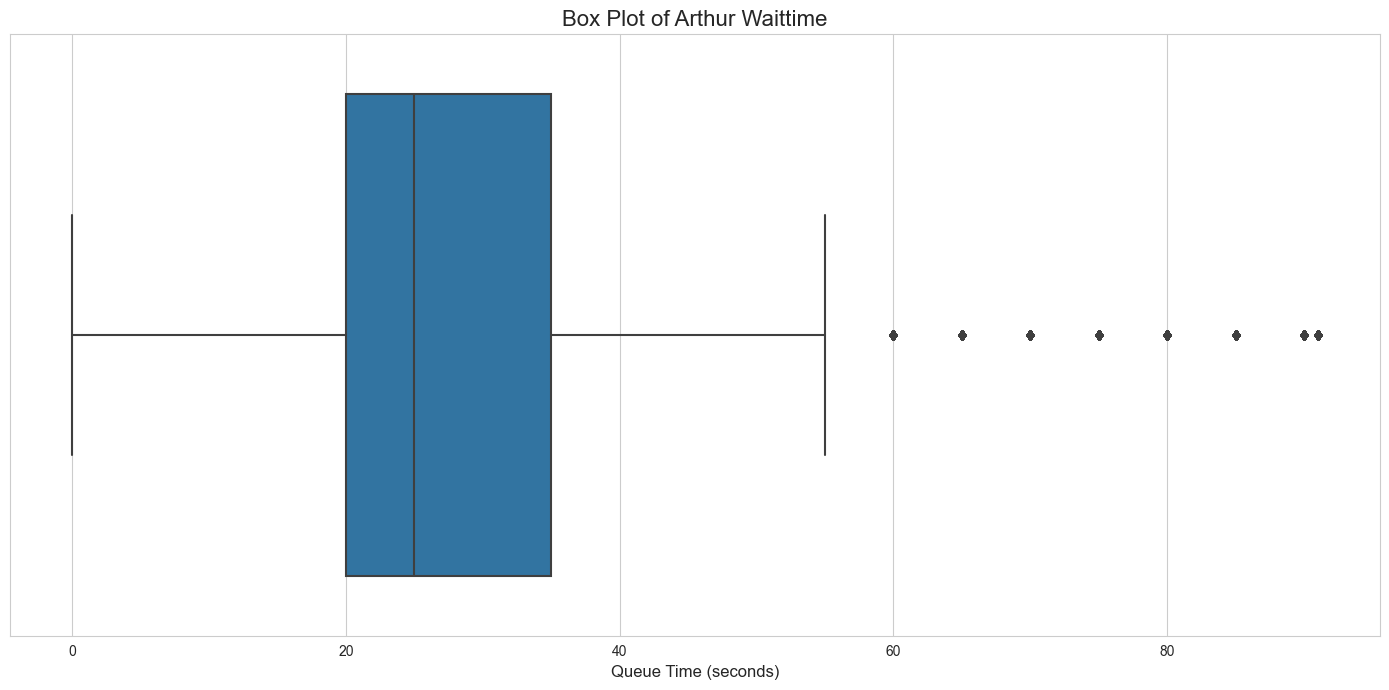

In [ ]:
# Box Plot of Queue Times to Identify Outliers
plt.figure(figsize=(14, 7))
sns.boxplot(x=df[QUEUE_TIME_COL])
plt.title(f'Box Plot of {QUEUE_TIME_COL.replace("_", " ").title()}', fontsize=16)
plt.xlabel('Queue Time (minutes)', fontsize=12)
plt.show()

### Bi-Variant analysis


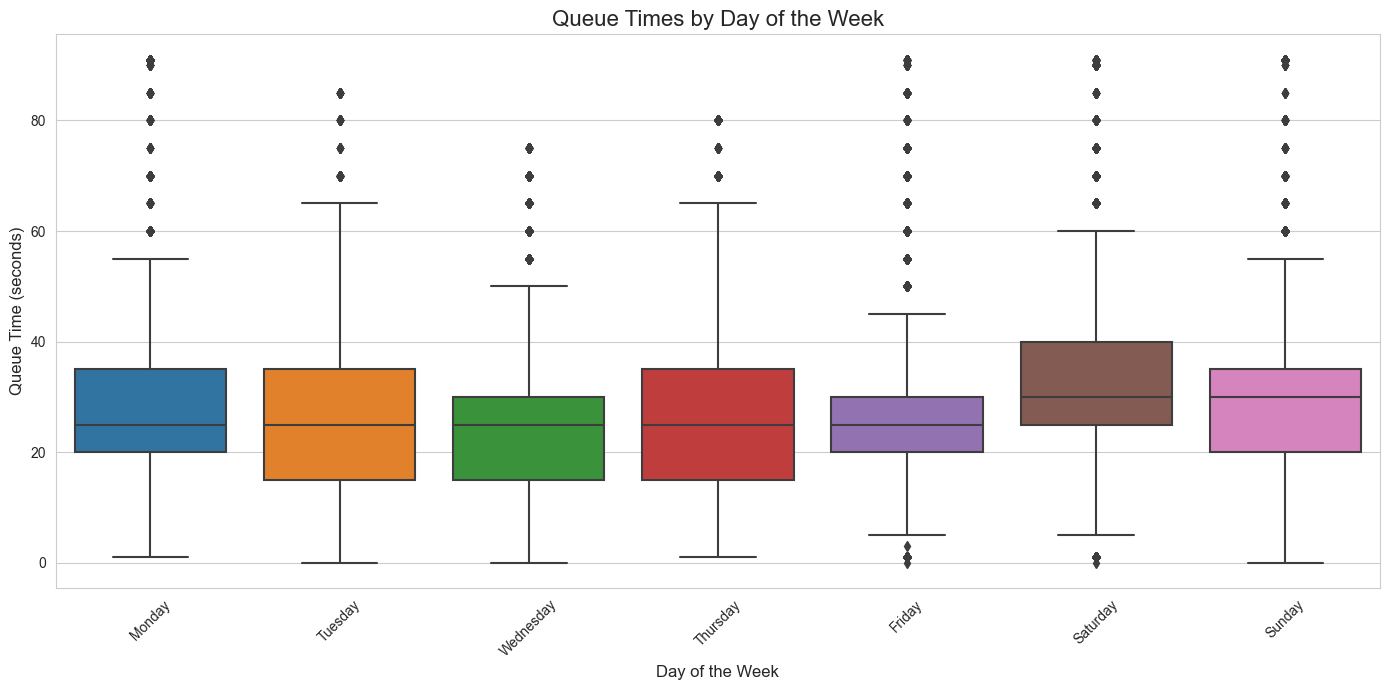

In [ ]:
# Queue Times by Day of the Week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='day_of_week', y=QUEUE_TIME_COL, order=day_order)
plt.title('Queue Times by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Queue Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

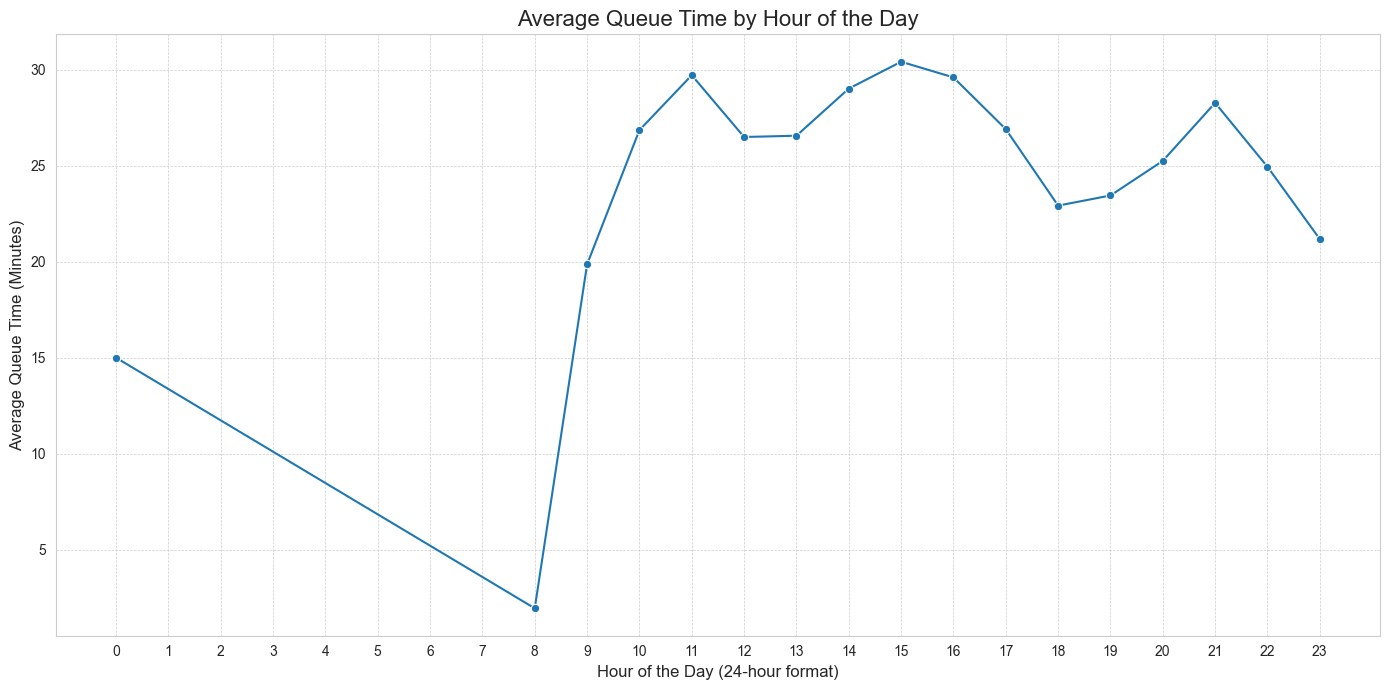

In [150]:
# Queue Times by Hour of the Day
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='hour', y=QUEUE_TIME_COL, ci=None, estimator='mean', marker='o')
plt.title('Average Queue Time by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Average Queue Time (Minutes)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

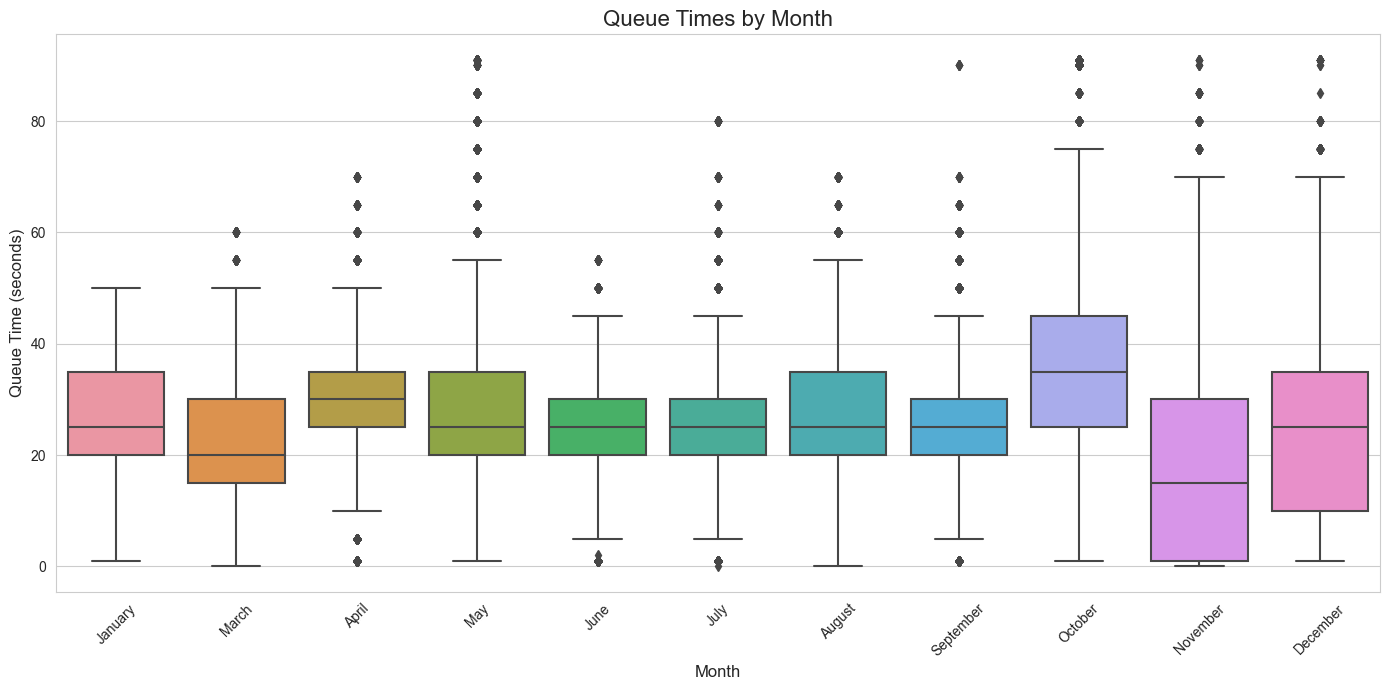

In [ ]:
# Queue Times by Month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Filter months present in the data
available_months = [m for m in month_order if m in df['month'].unique()]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='month', y=QUEUE_TIME_COL, order=available_months)
plt.title('Queue Times by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Queue Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Time-Series Analysis

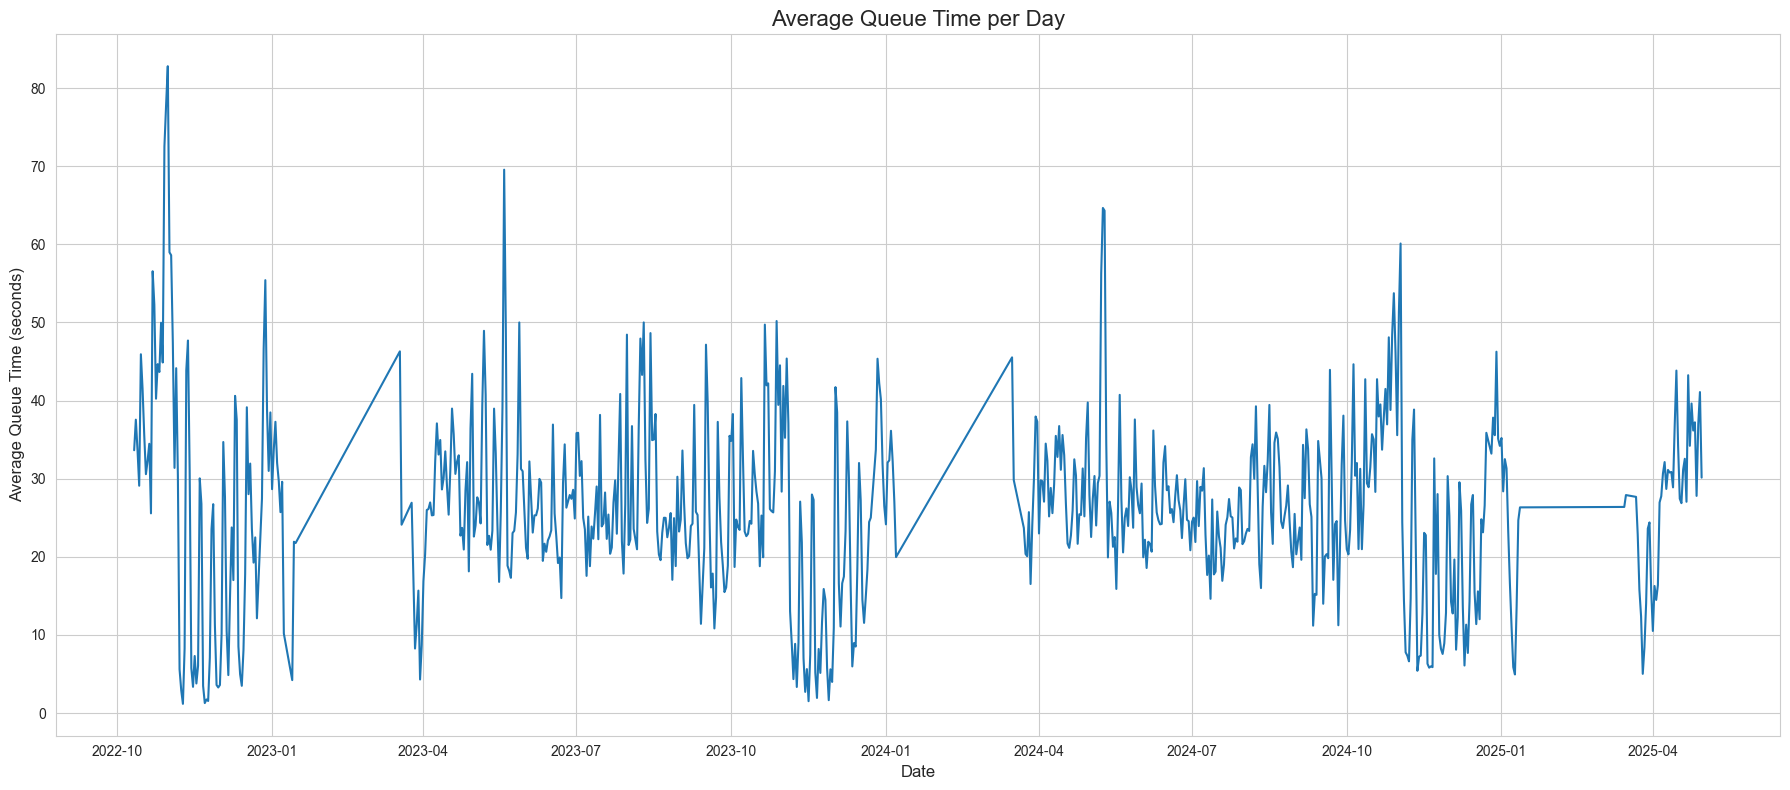

In [ ]:
# Average Queue Time Over Time (Daily)
daily_avg = df.groupby('date')[QUEUE_TIME_COL].mean().reset_index()
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

plt.figure(figsize=(18, 8))
plt.plot(daily_avg['date'], daily_avg[QUEUE_TIME_COL])
plt.title('Average Queue Time per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Queue Time (minutes)', fontsize=12)
plt.show()

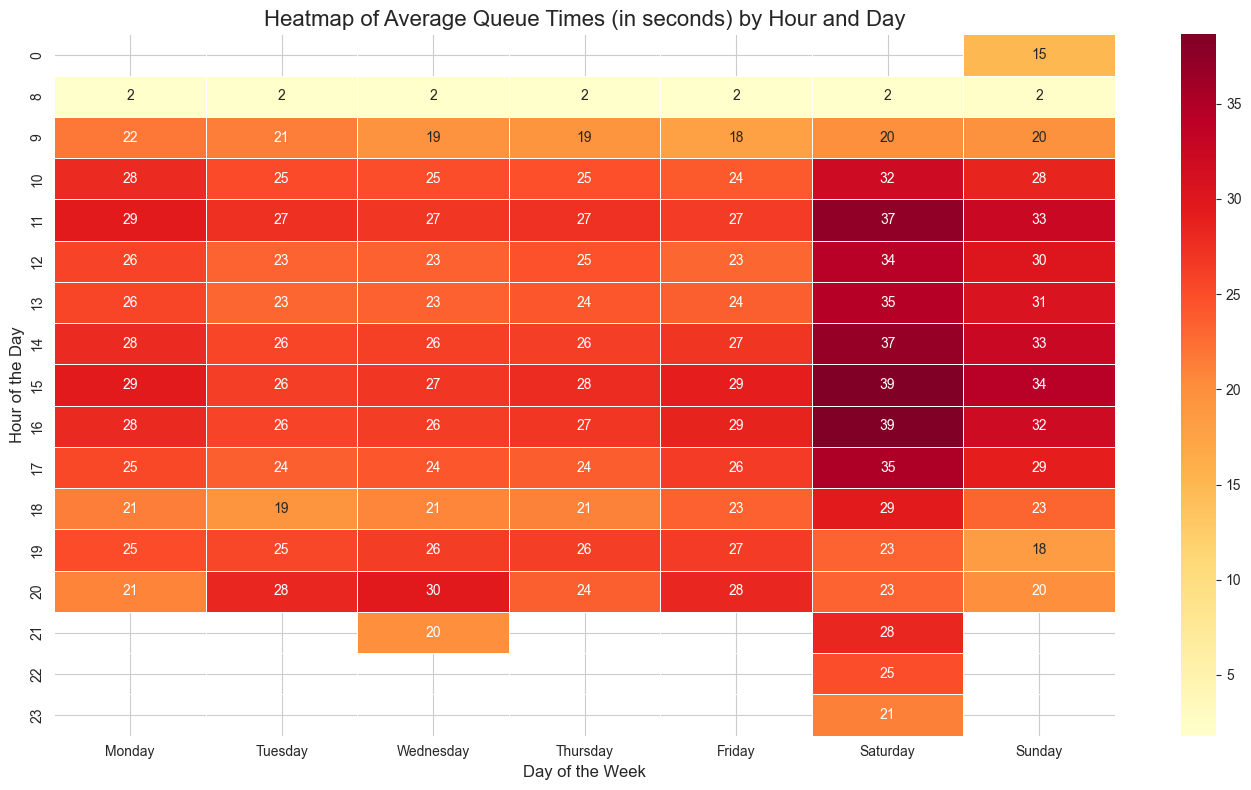

In [ ]:
# Heatmap of Queue Times by Day and Hour
# Pivot table to structure data for heatmap
pivot_table = df.pivot_table(values=QUEUE_TIME_COL, index='hour', columns='day_of_week', aggfunc='mean')
pivot_table = pivot_table.reindex(columns=day_order) # Order columns by day of the week

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=.5)
plt.title('Heatmap of Average Queue Times (in minutes) by Hour and Day', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)
plt.show()

### Multivariant analysis

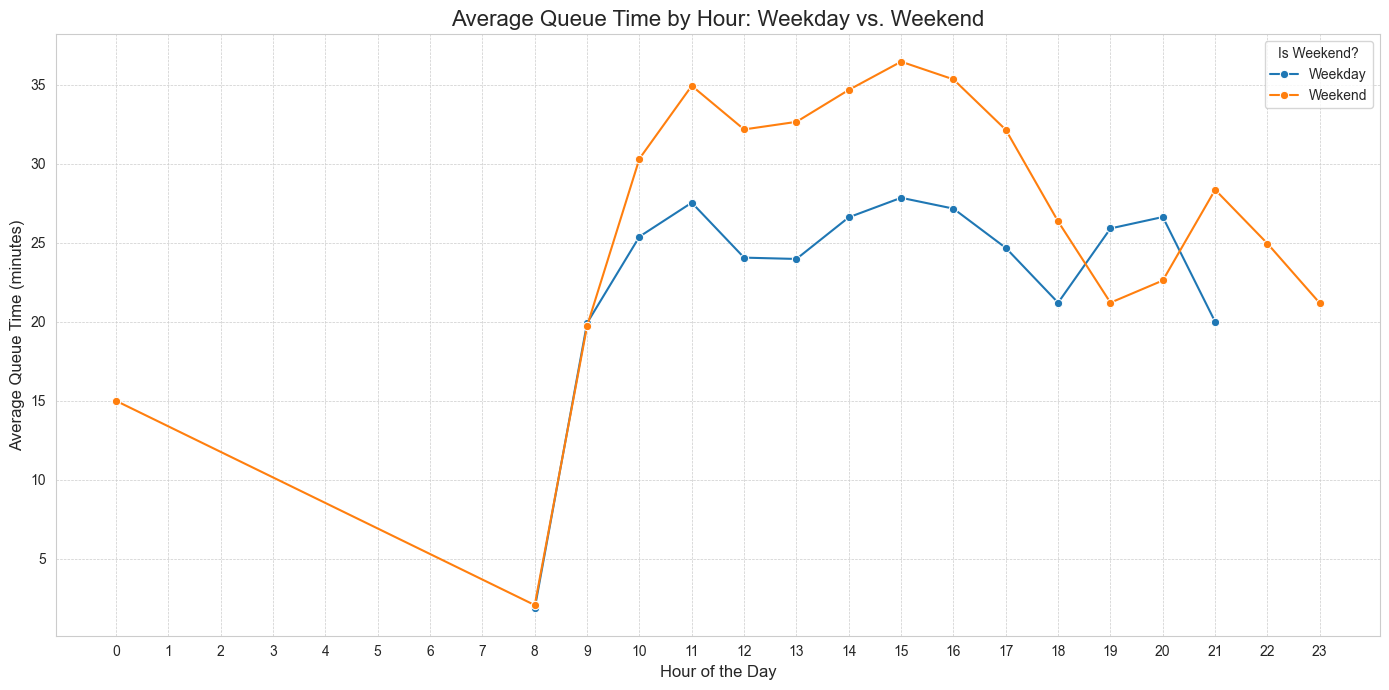

In [154]:
# Comparing Weekend vs. Weekday patterns by hour
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='hour', y=QUEUE_TIME_COL, hue='is_weekend', ci=None, estimator='mean', marker='o')
plt.title('Average Queue Time by Hour: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Queue Time (minutes)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend(title='Is Weekend?', labels=['Weekday', 'Weekend'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

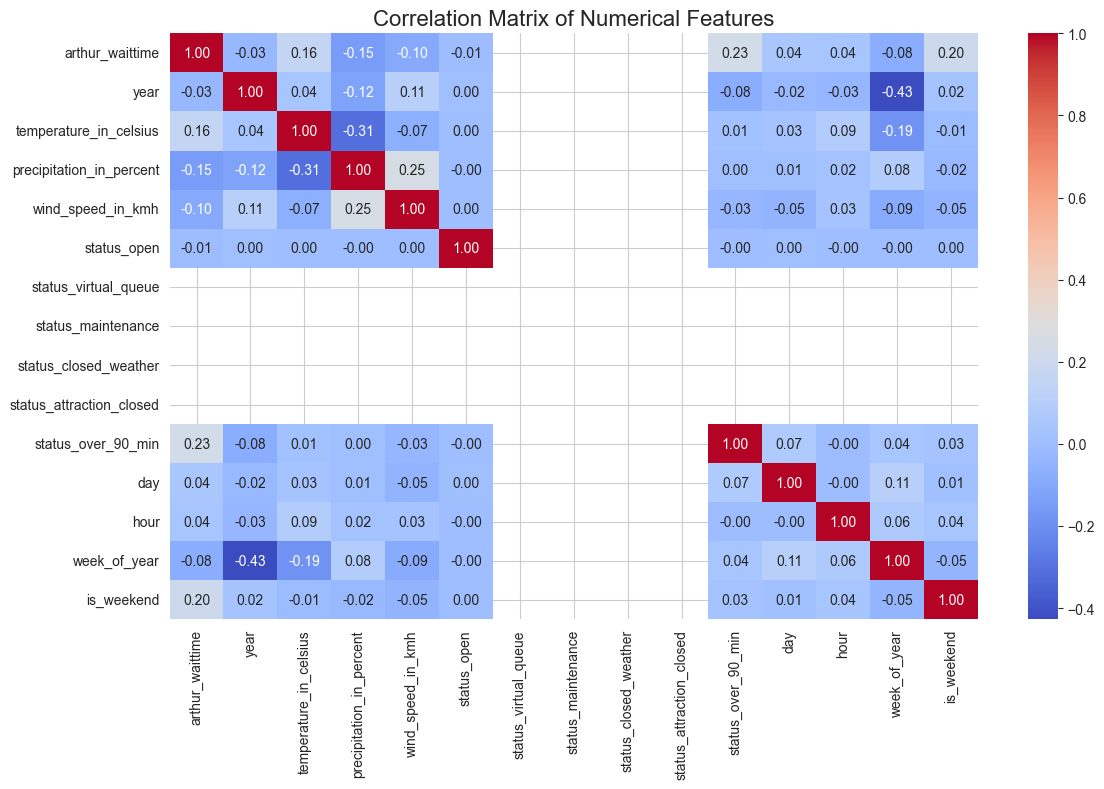

In [155]:
# Correlation Matrix
numerical_cols = df.select_dtypes(include=np.number)
correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

### Weather feature analysis with attraction waititng times


Plot 6: Analyzing the relationship between temperature and wait times...


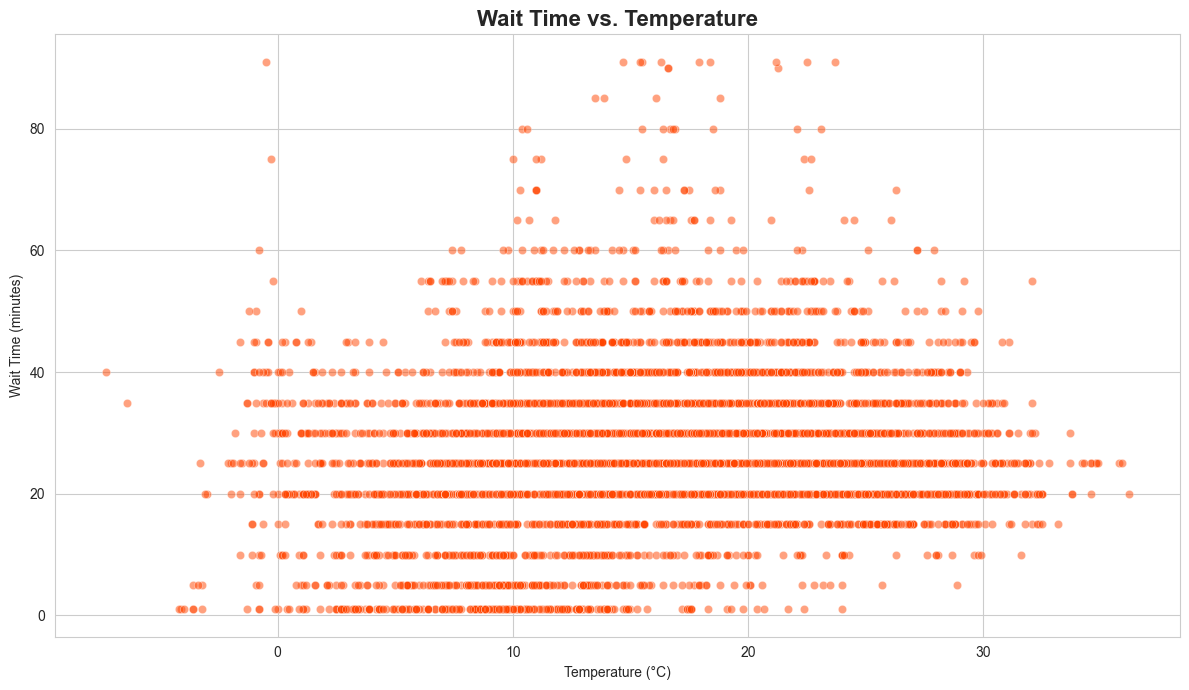

Insight: There does not appear to be a strong linear relationship. However, the longest wait times tend to occur during moderate temperatures (10-25°C), suggesting that very hot or very cold weather might deter park attendance.


In [156]:
# Temperature vs. Wait Time
print("\nPlot 6: Analyzing the relationship between temperature and wait times...")
plt.figure(figsize=(12, 7))
sns.scatterplot(x='temperature_in_celsius', y=TARGET, data=df.sample(5000), alpha=0.5, color='orangered')
plt.title('Wait Time vs. Temperature', fontsize=16, weight='bold')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wait Time (minutes)')
plt.tight_layout()
plt.show()
print("Insight: There does not appear to be a strong linear relationship. However, the longest wait times tend to occur during moderate temperatures (10-25°C), suggesting that very hot or very cold weather might deter park attendance.")



Analyzing the relationship between precipitation and wait times...


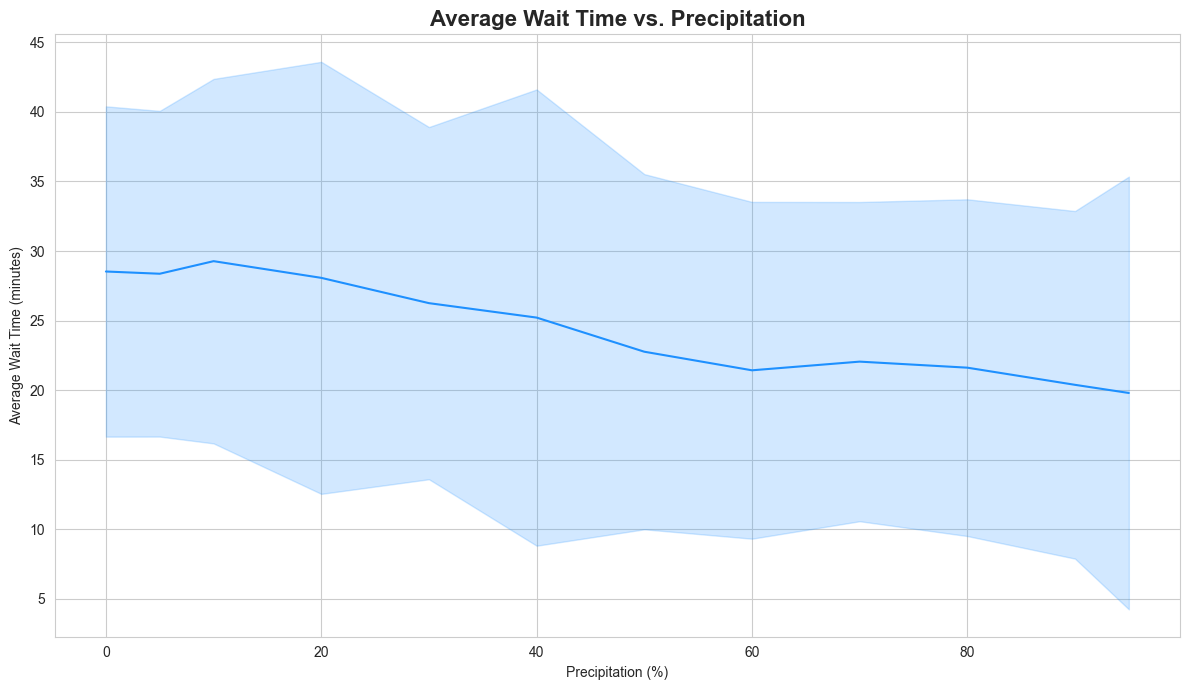

In [157]:
print("\nAnalyzing the relationship between precipitation and wait times...")
plt.figure(figsize=(12, 7))
sns.lineplot(x='precipitation_in_percent', y=TARGET, data=df, color='dodgerblue', estimator='mean', errorbar='sd')
plt.title('Average Wait Time vs. Precipitation', fontsize=16, weight='bold')
plt.xlabel('Precipitation (%)')
plt.ylabel('Average Wait Time (minutes)')
plt.tight_layout()
plt.show()


Analyzing the relationship between wind speed and wait times...


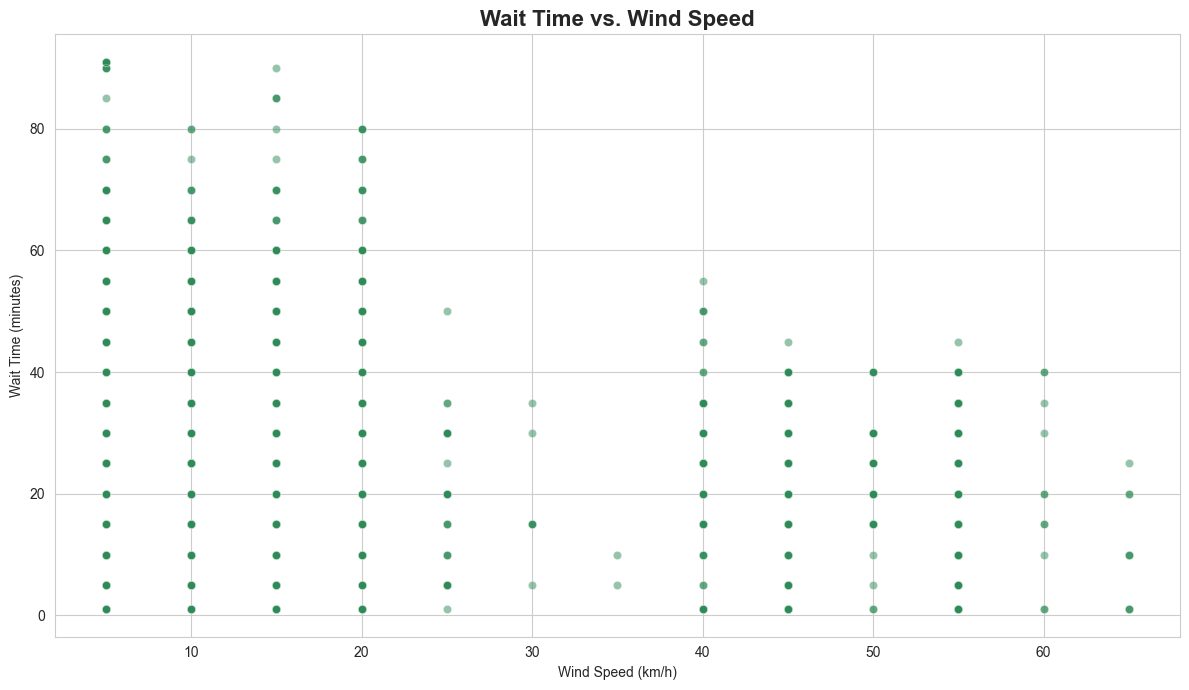

In [158]:
print("\nAnalyzing the relationship between wind speed and wait times...")
plt.figure(figsize=(12, 7))
sns.scatterplot(x='wind_speed_in_kmh', y=TARGET, data=df.sample(5000), alpha=0.5, color='seagreen')
plt.title('Wait Time vs. Wind Speed', fontsize=16, weight='bold')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Wait Time (minutes)')
plt.tight_layout()
plt.show()


Investigating seasonal patterns by comparing wait times across months...


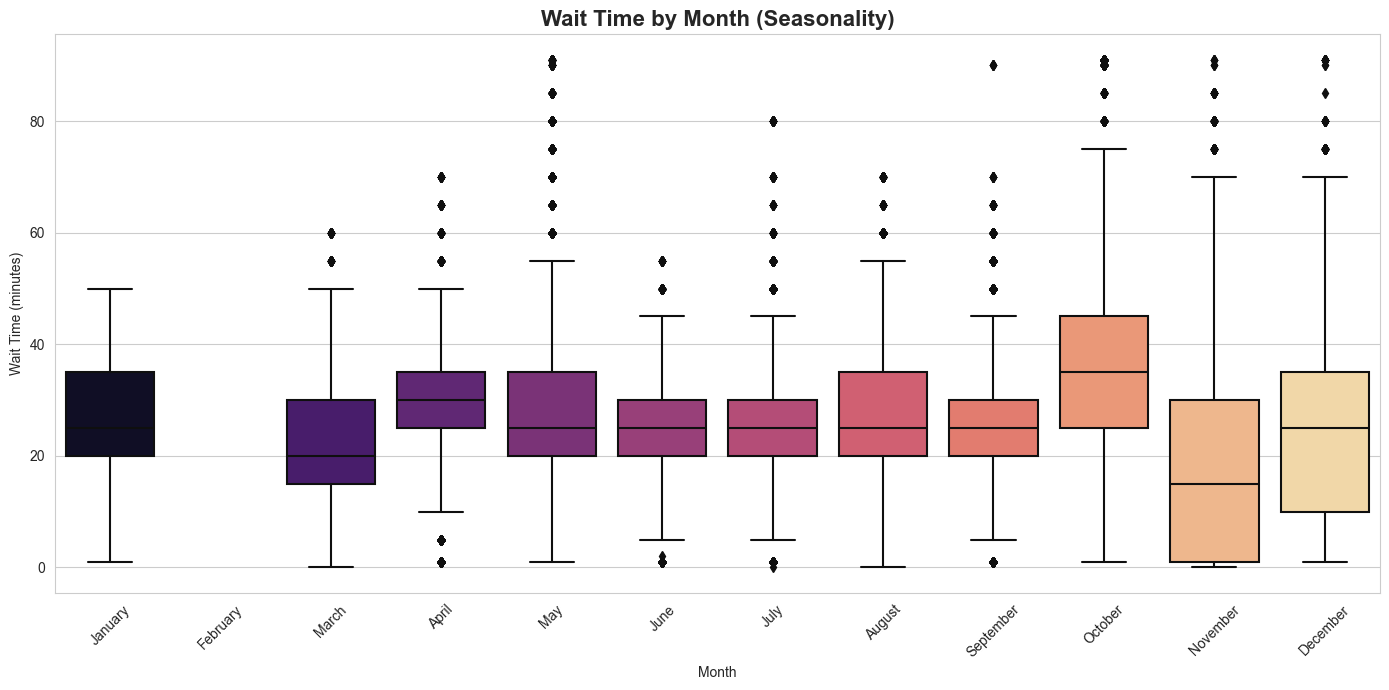

In [159]:
# Seasonality - Wait Times by Month
# FIX: Using month names directly for plotting to avoid potential library errors.
month_order_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
print("\nInvestigating seasonal patterns by comparing wait times across months...")
plt.figure(figsize=(14, 7))
sns.boxplot(x='month', y=TARGET, data=df, palette='magma', order=month_order_names)
plt.title('Wait Time by Month (Seasonality)', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature engineering

In [160]:
df.head()

,arthur_waittime,month,year,date,time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,datetime,status_open,status_virtual_queue,status_maintenance,status_closed_weather,status_attraction_closed,status_over_90_min,day,hour,day_of_week,week_of_year,is_weekend
99724,40.0,October,2022,2022-10-11,09:43,13.5,40.0,15.0,2022-10-11 09:43:00,0,0,0,0,0,0,11,9,Tuesday,41,0
99725,40.0,October,2022,2022-10-11,09:44,13.4,40.0,15.0,2022-10-11 09:44:00,0,0,0,0,0,0,11,9,Tuesday,41,0
99726,40.0,October,2022,2022-10-11,09:45,13.4,40.0,15.0,2022-10-11 09:45:00,0,0,0,0,0,0,11,9,Tuesday,41,0
99727,40.0,October,2022,2022-10-11,09:46,13.4,40.0,15.0,2022-10-11 09:46:00,0,0,0,0,0,0,11,9,Tuesday,41,0
99728,40.0,October,2022,2022-10-11,09:47,13.4,40.0,15.0,2022-10-11 09:47:00,0,0,0,0,0,0,11,9,Tuesday,41,0


In [161]:
#Developed using Generative AI models
def create_lagged_features(df, max_lag, column_to_lag='arthur_waittime'):
    """
    Creates lagged features for a specific column in a DataFrame.

    Args:
        df (pd.DataFrame): The input dataframe.
        column_to_lag (str): The name of the column to create lags for.
        max_lag (int): The maximum number of time steps to shift back.

    Returns:
        pd.DataFrame: The dataframe with new lagged features.
    """
    df_lagged = df.copy()
    print(f"Creating {max_lag} lagged features for column: '{column_to_lag}'")
    for lag in range(1, max_lag + 1):
        # Shift the specific column by 'lag' steps
        shifted = df_lagged[column_to_lag].shift(lag)
        # Add it as a new column with a descriptive name
        df_lagged[f'{column_to_lag}_lag_{lag}'] = shifted
    # Drop rows with NaN values created by the shift operation
    df_lagged = df_lagged.dropna()
    return df_lagged

In [162]:
app_1 = create_lagged_features(df,10,column_to_lag='arthur_waittime')

Creating 10 lagged features for column: 'arthur_waittime'


In [163]:
app_1.columns

Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10'],
      dtype='object')

## ML Modelling part with different approaches

### Task 1: Create a Baseline predicting model for the initial dataset without using Lagging variable

In [164]:
target_col = QUEUE_TIME_COL

In [165]:
task_1 = df.copy()

In [166]:
task_1 = task_1.sort_values(by=DATE_COL)


In [167]:
task_1.columns

Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend'],
      dtype='object')

In [168]:
features = [ 'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'week_of_year', 'is_weekend']

Mean Absolute Error (MAE): 7.6595

Feature Importance:
                     Feature  Importance
8         status_over_90_min    0.353052
11              week_of_year    0.207555
12                is_weekend    0.153593
10                      hour    0.092633
1   precipitation_in_percent    0.064581
0     temperature_in_celsius    0.057971
9                        day    0.045578
2          wind_speed_in_kmh    0.025037
3                status_open    0.000000
4       status_virtual_queue    0.000000
5         status_maintenance    0.000000
6      status_closed_weather    0.000000
7   status_attraction_closed    0.000000


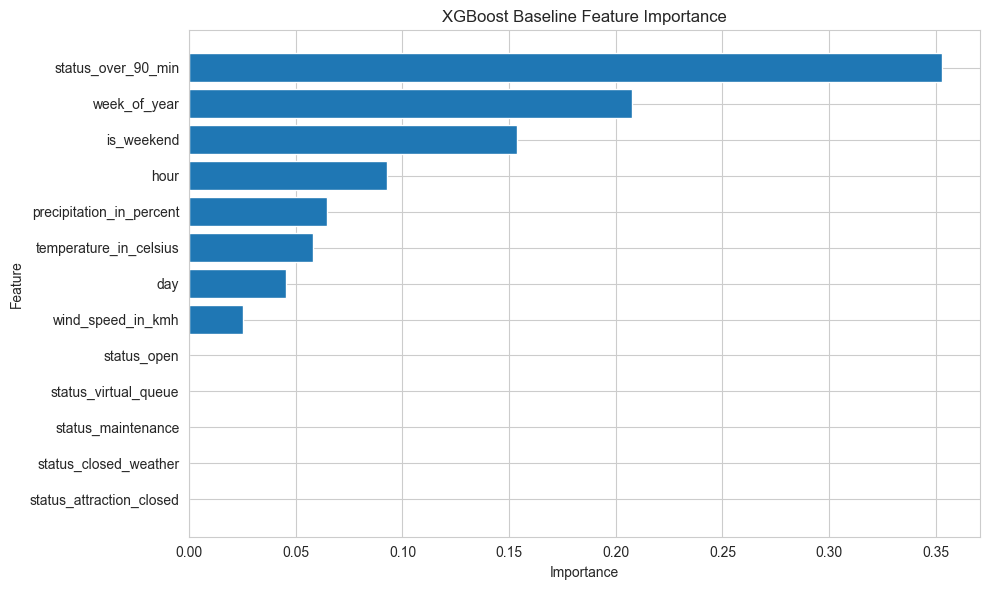

In [169]:
y = task_1[target_col]
X = task_1[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

xgb_model = XGBRegressor(
    objective='reg:squarederror', n_estimators=200, learning_rate=0.05,
    max_depth=2, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate and print MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Show feature importance
feature_importances = xgb_model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(features_df)

# You can also visualize the feature importance if you have matplotlib installed
# import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Baseline Feature Importance")
plt.gca().invert_yaxis() # To have the most important feature at the top
plt.show()

### Task 2: Create a XGBoost ML model for the initial dataset using Lagging variable

In [170]:
app_1_df = app_1.copy()

In [171]:
app_1_df.columns

Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10'],
      dtype='object')

In [172]:
app_1_df = app_1_df.sort_values(by=DATE_COL)

In [173]:
cat_columns = ['month', 'date', 'time', 'day_of_week']
num_columns = ['arthur_waittime', 'year', 'temperature_in_celsius', 'precipitation_in_percent',
                'wind_speed_in_kmh', 'status_open', 'status_virtual_queue', 'status_maintenance',
                'status_closed_weather', 'status_attraction_closed', 'status_over_90_min',
                'day', 'hour', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
                'arthur_waittime_lag_2', 'arthur_waittime_lag_3', 'arthur_waittime_lag_4',
                'arthur_waittime_lag_5', 'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
                'arthur_waittime_lag_8', 'arthur_waittime_lag_9', 'arthur_waittime_lag_10']

print("Categorical columns:", cat_columns)
print("Numerical columns:", num_columns)


Categorical columns: ['month', 'date', 'time', 'day_of_week']
Numerical columns: ['arthur_waittime', 'year', 'temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh', 'status_open', 'status_virtual_queue', 'status_maintenance', 'status_closed_weather', 'status_attraction_closed', 'status_over_90_min', 'day', 'hour', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1', 'arthur_waittime_lag_2', 'arthur_waittime_lag_3', 'arthur_waittime_lag_4', 'arthur_waittime_lag_5', 'arthur_waittime_lag_6', 'arthur_waittime_lag_7', 'arthur_waittime_lag_8', 'arthur_waittime_lag_9', 'arthur_waittime_lag_10']


In [174]:
print(app_1_df[cat_columns])

          month        date   time day_of_week
99734   October  2022-10-11  09:53     Tuesday
99735   October  2022-10-11  09:54     Tuesday
99736   October  2022-10-11  09:55     Tuesday
99737   October  2022-10-11  09:56     Tuesday
99738   October  2022-10-11  09:57     Tuesday
...         ...         ...    ...         ...
534630    April  2025-04-30  18:55   Wednesday
534631    April  2025-04-30  18:56   Wednesday
534632    April  2025-04-30  18:57   Wednesday
534633    April  2025-04-30  18:58   Wednesday
534634    April  2025-04-30  18:59   Wednesday

[418312 rows x 4 columns]


In [175]:
target_col = QUEUE_TIME_COL
features_to_drop = ['month', 'datetime','date', 'time']

In [176]:
app_1_df = app_1_df.drop(columns=features_to_drop)
dummy_col = ['day_of_week']

In [177]:
app_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418312 entries, 99734 to 534634
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   arthur_waittime           418312 non-null  float64
 1   year                      418312 non-null  int64  
 2   temperature_in_celsius    418312 non-null  float64
 3   precipitation_in_percent  418312 non-null  float64
 4   wind_speed_in_kmh         418312 non-null  float64
 5   status_open               418312 non-null  int32  
 6   status_virtual_queue      418312 non-null  int32  
 7   status_maintenance        418312 non-null  int32  
 8   status_closed_weather     418312 non-null  int32  
 9   status_attraction_closed  418312 non-null  int32  
 10  status_over_90_min        418312 non-null  int32  
 11  day                       418312 non-null  int64  
 12  hour                      418312 non-null  int64  
 13  day_of_week               418312 non-nul

In [178]:
y = app_1_df[target_col]
X_preproc = app_1_df.drop(columns=target_col)

# Using pd.get_dummies is a straightforward way to one-hot encode
X = pd.get_dummies(X_preproc, columns=dummy_col, drop_first=True)

In [179]:
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculates the adjusted R-squared score.

    Args:
        y_true: True target values.
        y_pred: Predicted values.
        n_features: The number of features used for the prediction.

    Returns:
        The adjusted R-squared score.
    """
    # Calculate regular R-squared
    r2 = r2_score(y_true, y_pred)
    # Get the number of samples
    n_samples = len(y_true)
    # Calculate adjusted R-squared
    # The formula protects against division by zero if n_samples is too small
    denominator = (n_samples - n_features - 1)
    if denominator == 0:
        return r2 # Fallback to regular r2 if denominator is zero
    return 1 - (1 - r2) * (n_samples - 1) / denominator

In [180]:
train_splits = np.arange(0.6, 0.80, 0.05)
results_log = []
for split_ratio in train_splits:
    print(f"\n--- Running for training split ratio: {split_ratio:.2f} ---")

    test_ratio = 1 - split_ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    # XGBoost Regressor
    xgb_model = XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    xgb_preds = xgb_model.predict(X_test)
    num_features = X_test.shape[1]

    for model_name, preds in [('XGBoost', xgb_preds)]:

        # Standard metrics
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        medae = median_absolute_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        adj_r2 = adjusted_r2_score(y_test, preds, n_features=num_features)

        # Append the comprehensive dictionary of results
        results_log.append({
            'split_ratio': split_ratio,
            'model': model_name,
            'r_squared': r2,
            'adjusted_r_squared': adj_r2,
            'rmse': rmse,
            'mae': mae,
            'medae': medae,
            'mape': mape
        })



print("\n--- Iterative training complete. ---")



--- Running for training split ratio: 0.60 ---

--- Running for training split ratio: 0.65 ---

--- Running for training split ratio: 0.70 ---

--- Running for training split ratio: 0.75 ---

--- Running for training split ratio: 0.80 ---

--- Iterative training complete. ---


In [181]:
df_original = df.copy()
if np.isclose(split_ratio, train_splits[-1]):
        print("\nStoring final models for detailed analysis.")
        final_xgb_model = xgb_model
        final_X_test = X_test
        final_y_test = y_test

        final_test_indices = final_y_test.index

        # --- SOLUTION IMPLEMENTED HERE ---
        # Use the pristine 'df_original' for the lookup, not the potentially modified 'df'
        print("Looking up rows in 'df_original'...")
        final_test_rows = df_original.loc[final_test_indices]
        print("Lookup successful!")

        # Now you can safely get any original column data you need
        final_test_dates = final_test_rows['datetime'] # Or your actual date column


Storing final models for detailed analysis.
Looking up rows in 'df_original'...
Lookup successful!


In [182]:
final_test_rows['arthur_waittime'].value_counts()

30.0    11803
25.0    11785
20.0     9889
35.0     9837
15.0     7381
40.0     7181
5.0      6381
10.0     4898
45.0     4454
1.0      4369
50.0     2390
55.0     1431
60.0      895
70.0      407
65.0      321
80.0      108
75.0       88
91.0       32
90.0        5
85.0        4
0.0         4
Name: arthur_waittime, dtype: int64

In [219]:
results_df_log.sort_values(by='mae')

,split_ratio,model,r_squared,adjusted_r_squared,rmse,mae,medae,mape
2,0.70,XGBoost,0.987888,0.987886,1.452070,0.548841,0.141624,1.327629e+12
1,0.65,XGBoost,0.986320,0.986317,1.474899,0.553504,0.127638,1.326502e+12
0,0.60,XGBoost,0.985339,0.985336,1.472124,0.558710,0.127636,1.055495e+12
3,0.75,XGBoost,0.986982,0.986978,1.572585,0.620083,0.142432,1.221982e+12
4,0.80,XGBoost,0.987383,0.987378,1.631290,0.663592,0.159124,1.536449e+12



--- 6. Performance Analysis vs. Training Size ---


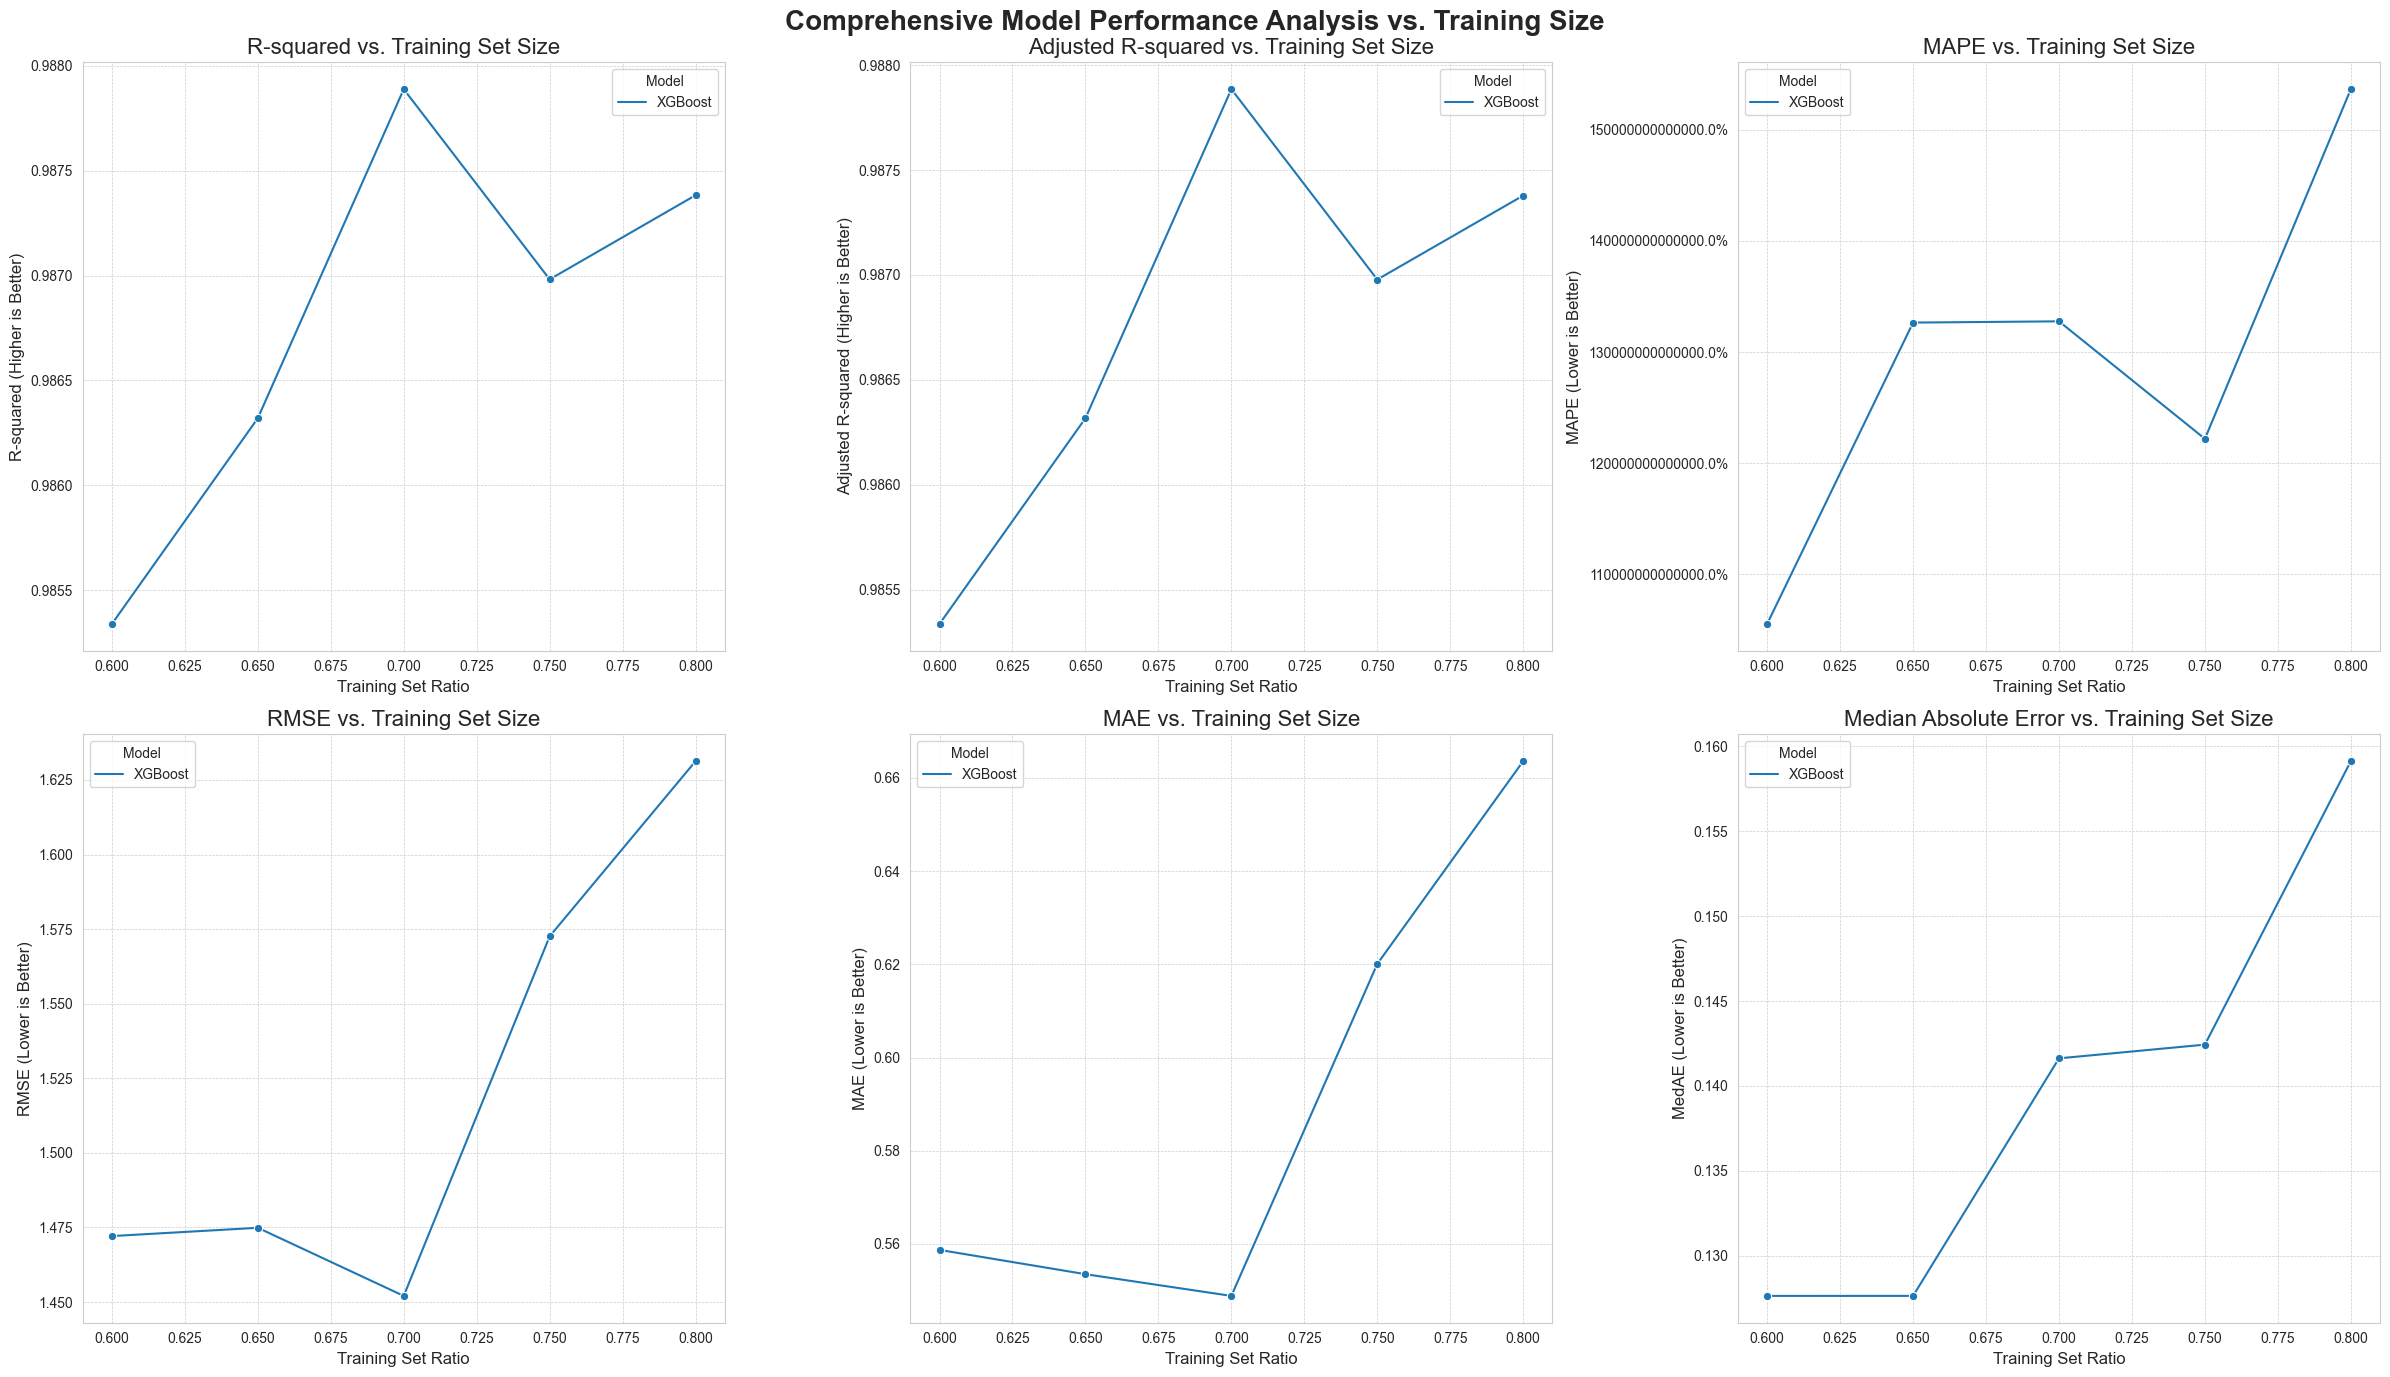

In [183]:
# --- 6. PERFORMANCE ANALYSIS VS. TRAINING SIZE (EXPANDED) ---
print("\n--- 6. Performance Analysis vs. Training Size ---")

# Convert the log into a DataFrame
# This DataFrame now contains all the calculated metrics
results_df_log = pd.DataFrame(results_log)

# Ensure the column names here match the keys in your results_log dictionary
# Expected columns: 'split_ratio', 'model', 'r_squared', 'adjusted_r_squared', 'rmse', 'mae', 'medae', 'mape'

# --- Create a 2x3 grid of subplots for a comprehensive view ---
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Comprehensive Model Performance Analysis vs. Training Size', fontsize=20, fontweight='bold')

# --- Plot 1: R-squared (Original) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='r_squared', hue='model', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('R-squared vs. Training Set Size', fontsize=16)
axes[0, 0].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 0].set_ylabel('R-squared (Higher is Better)', fontsize=12)
axes[0, 0].legend(title='Model')
axes[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: Adjusted R-squared (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='adjusted_r_squared', hue='model', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Adjusted R-squared vs. Training Set Size', fontsize=16)
axes[0, 1].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 1].set_ylabel('Adjusted R-squared (Higher is Better)', fontsize=12)
axes[0, 1].legend(title='Model')
axes[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 3: Mean Absolute Percentage Error (MAPE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='mape', hue='model', marker='o', ax=axes[0, 2])
axes[0, 2].set_title('MAPE vs. Training Set Size', fontsize=16)
axes[0, 2].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 2].set_ylabel('MAPE (Lower is Better)', fontsize=12)
axes[0, 2].yaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format)) # Format y-axis as percentage
axes[0, 2].legend(title='Model')
axes[0, 2].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 4: Root Mean Squared Error (RMSE) (Original) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='rmse', hue='model', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('RMSE vs. Training Set Size', fontsize=16)
axes[1, 0].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 0].set_ylabel('RMSE (Lower is Better)', fontsize=12)
axes[1, 0].legend(title='Model')
axes[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 5: Mean Absolute Error (MAE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='mae', hue='model', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('MAE vs. Training Set Size', fontsize=16)
axes[1, 1].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 1].set_ylabel('MAE (Lower is Better)', fontsize=12)
axes[1, 1].legend(title='Model')
axes[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 6: Median Absolute Error (MedAE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='medae', hue='model', marker='o', ax=axes[1, 2])
axes[1, 2].set_title('Median Absolute Error vs. Training Set Size', fontsize=16)
axes[1, 2].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 2].set_ylabel('MedAE (Lower is Better)', fontsize=12)
axes[1, 2].legend(title='Model')
axes[1, 2].grid(True, which='both', linestyle='--', linewidth=0.5)


# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for suptitle
plt.show()

In [184]:
# !pip install shap
import shap
# --- 1. Calculate SHAP values ---
# Create an explainer object. For tree models like XGBoost, TreeExplainer is fast.
# Using shap.Explainer is a robust way as it often auto-selects the best explainer.
print("\n--- Calculating SHAP values for the test set... ---")
explainer = shap.Explainer(final_xgb_model)
shap_values = explainer(X_test)
print("--- SHAP calculation complete. ---")

# The shap_values object contains the SHAP values for every feature of every instance in X_test


--- Calculating SHAP values for the test set... ---
--- SHAP calculation complete. ---



--- Generating SHAP Summary Plot (Global Importance) ---


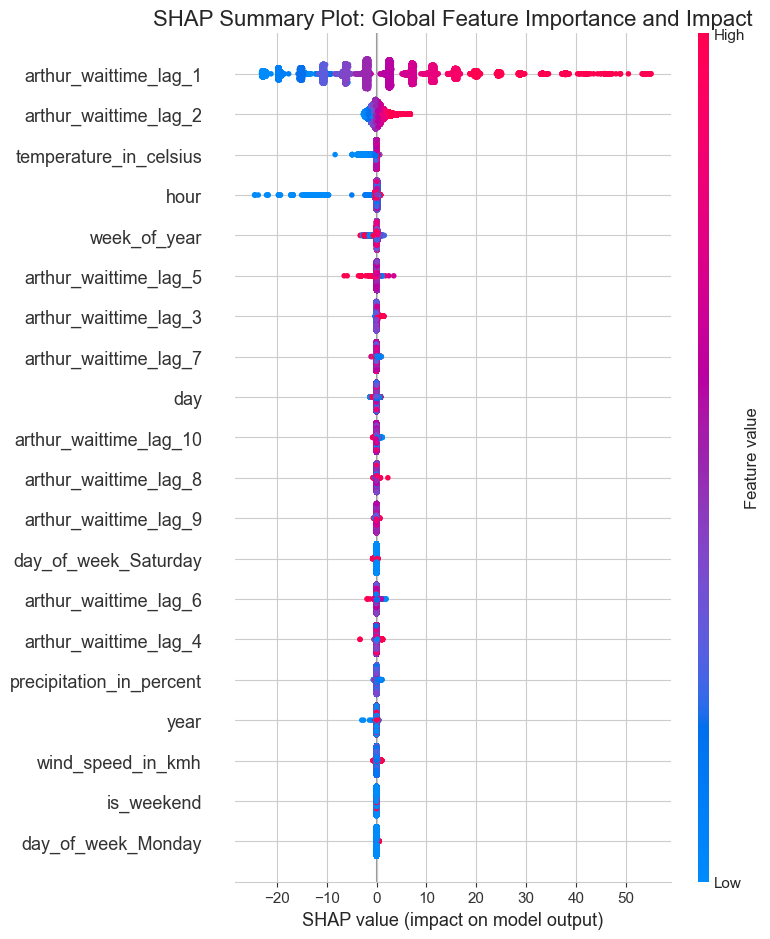

In [185]:
# --- 2. Global Feature Importance (Beeswarm Plot) ---
print("\n--- Generating SHAP Summary Plot (Global Importance) ---")

# This plot is a rich combination of feature importance and feature effects.
# Each dot is a single prediction's SHAP value for a single feature.
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot: Global Feature Importance and Impact", fontsize=16)
plt.show()

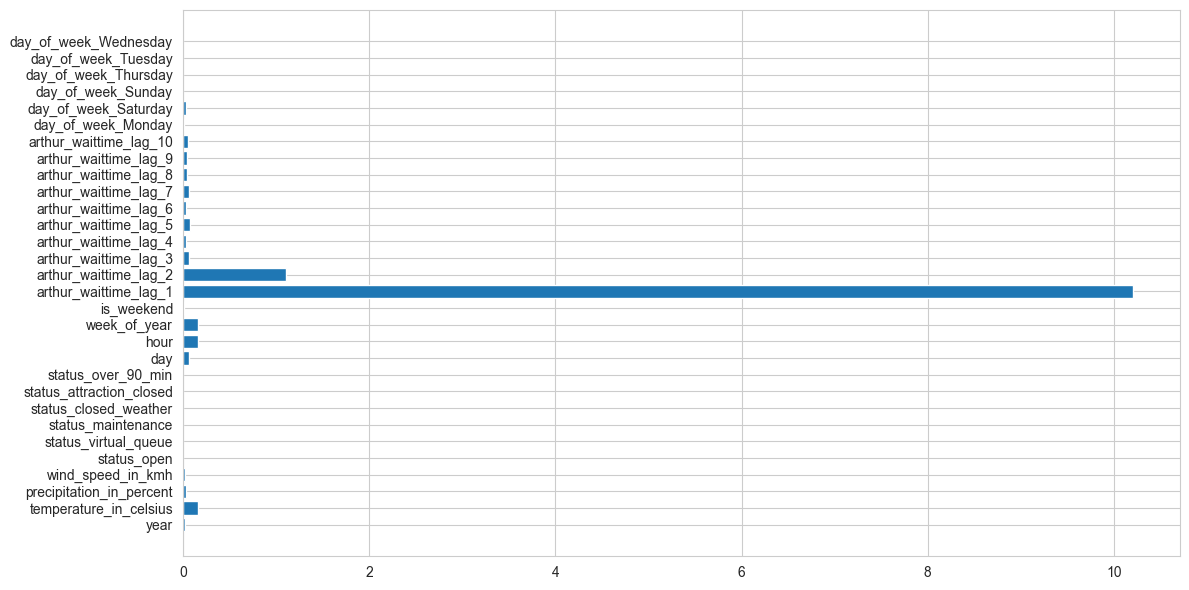

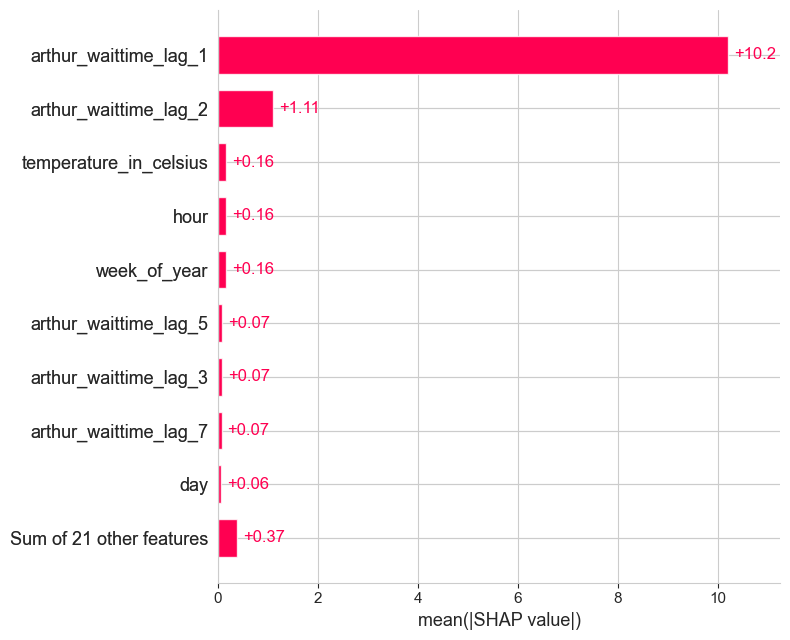

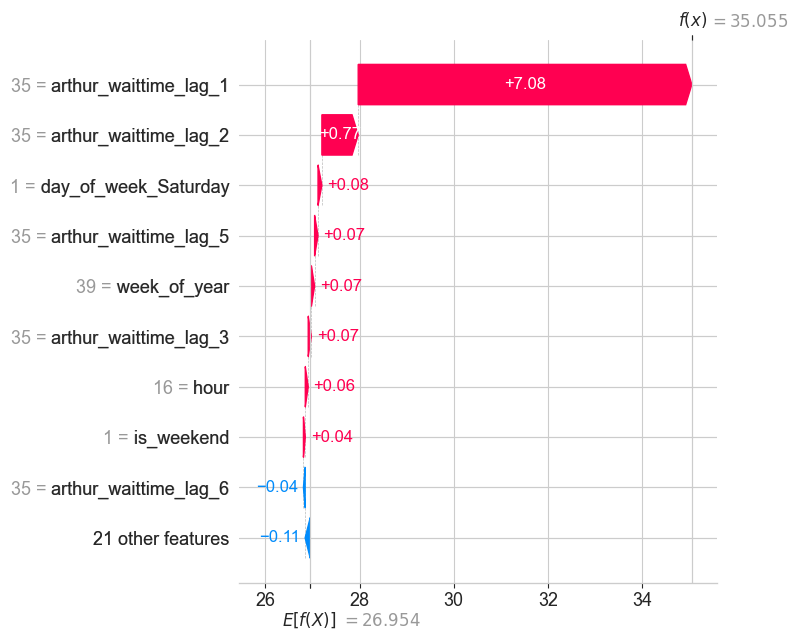

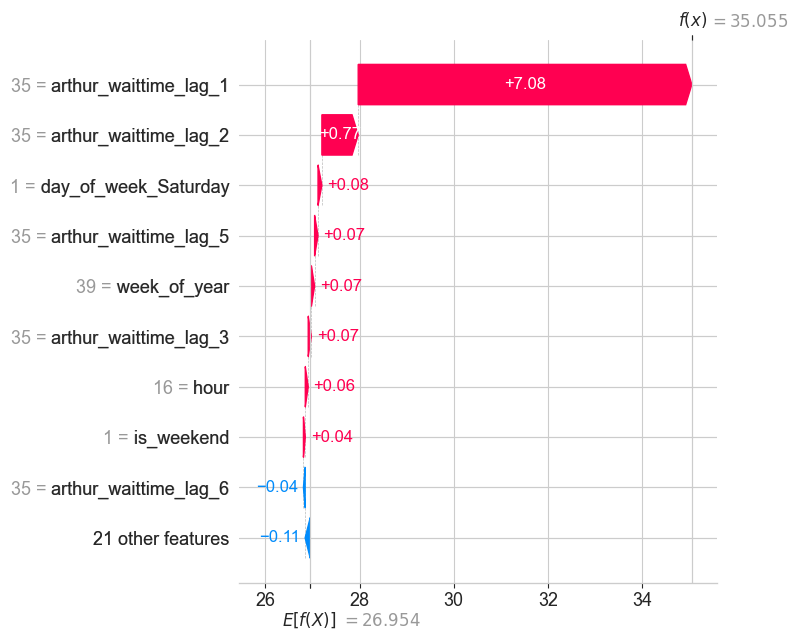

In [186]:

global_shap=np.mean(np.abs(shap_values.values),axis=0)
plt.barh(X_test.columns,global_shap)
plt.show()
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0], max_display=10)
shap.plots.waterfall(shap_values[1], max_display=10)


--- Generating SHAP Dependence Plots to check for interactions ---


<Figure size 1200x600 with 0 Axes>

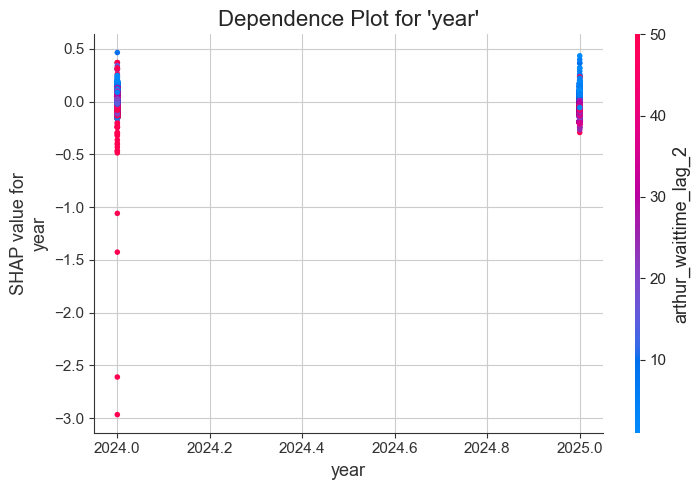

<Figure size 1200x600 with 0 Axes>

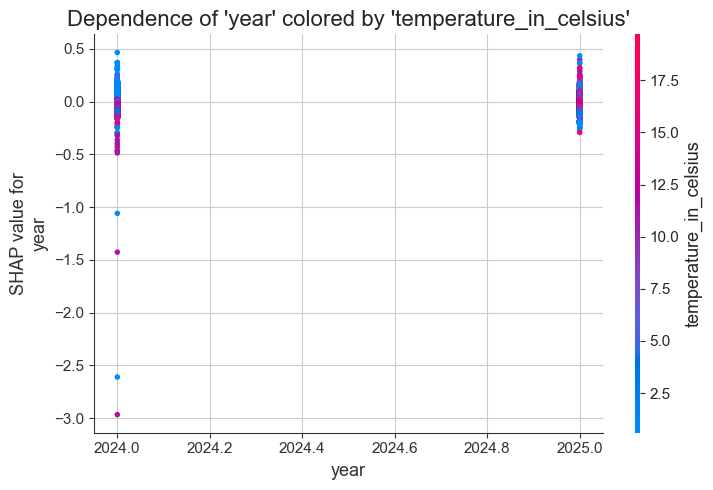

In [187]:
# --- 3. Feature Interaction Analysis (Dependence Plots) ---
print("\n--- Generating SHAP Dependence Plots to check for interactions ---")

# Let's assume your top 2 most important features from the summary plot are 'feature_A' and 'feature_B'
# Replace 'feature_A' and 'feature_B' with the actual column names from your data.
# For this example, I'll just use the first two columns of X_test.
top_feature = X_test.columns[0]
second_top_feature = X_test.columns[1]


# Plot the dependence of the top feature
# The plot will automatically color by another feature that it most interacts with.
plt.figure()
shap.dependence_plot(top_feature, shap_values.values, X_test, show=False)
plt.title(f"Dependence Plot for '{top_feature}'", fontsize=16)
plt.show()


# You can also explicitly specify which feature to use for coloring to investigate a suspected interaction.
plt.figure()
shap.dependence_plot(
    top_feature,
    shap_values.values,
    X_test,
    interaction_index=second_top_feature,
    show=False
)
plt.title(f"Dependence of '{top_feature}' colored by '{second_top_feature}'", fontsize=16)
plt.show()


--- 7. Feature Importance Analysis (Final XGBoost Model) ---


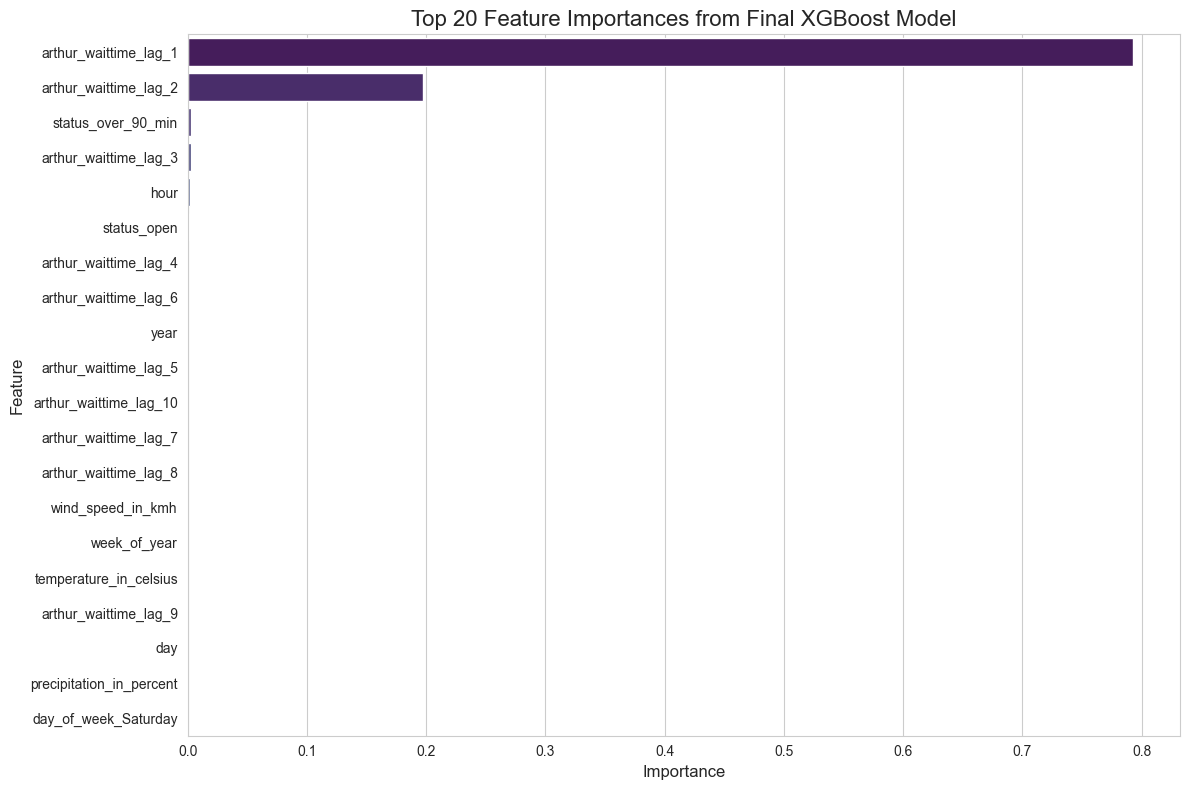

In [188]:
# --- 7. DETAILED ANALYSIS OF FINAL MODEL ---
print("\n--- 7. Feature Importance Analysis (Final XGBoost Model) ---")

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': final_xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Top 20 Feature Importances from Final XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()





 Visualize Predictions of Final Models


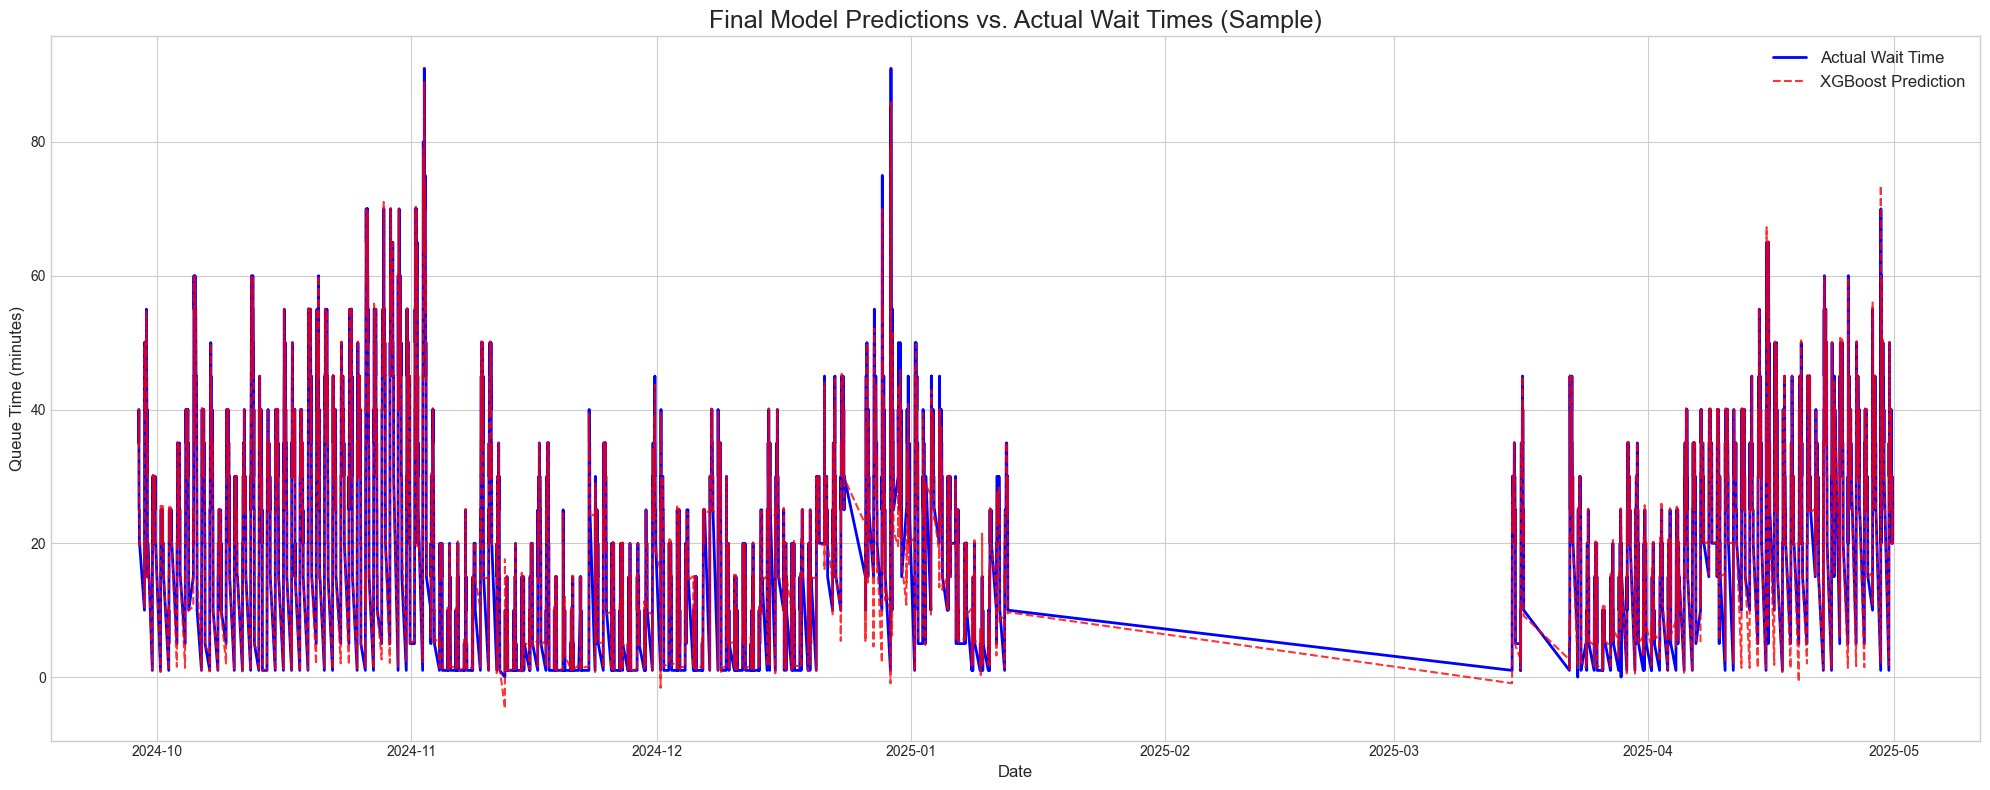

In [193]:
# VISUALIZE PREDICTIONS (FINAL MODEL)
print("\n Visualize Predictions of Final Models")

# Get predictions from the final models
final_xgb_preds = final_xgb_model.predict(final_X_test)

# Create a dataframe for easy plotting
final_results_df = pd.DataFrame({
    'date': final_test_dates,
    'actual_wait_time': final_y_test,
    'xgb_predicted_time': final_xgb_preds
})

# Plot a sample of the results (e.g., the first 500 test points) to keep it readable
plt.figure(figsize=(20, 8))
plt.plot(final_results_df['date'], final_results_df['actual_wait_time'], label='Actual Wait Time', color='blue', linewidth=2)
plt.plot(final_results_df['date'], final_results_df['xgb_predicted_time'], label='XGBoost Prediction', color='red', linestyle='--', alpha=0.8)
plt.title('Final Model Predictions vs. Actual Wait Times (Sample)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Queue Time (minutes)', fontsize=12)
plt.legend(fontsize=12)
plt.show()


Plotting the first 500 data points of the test set...


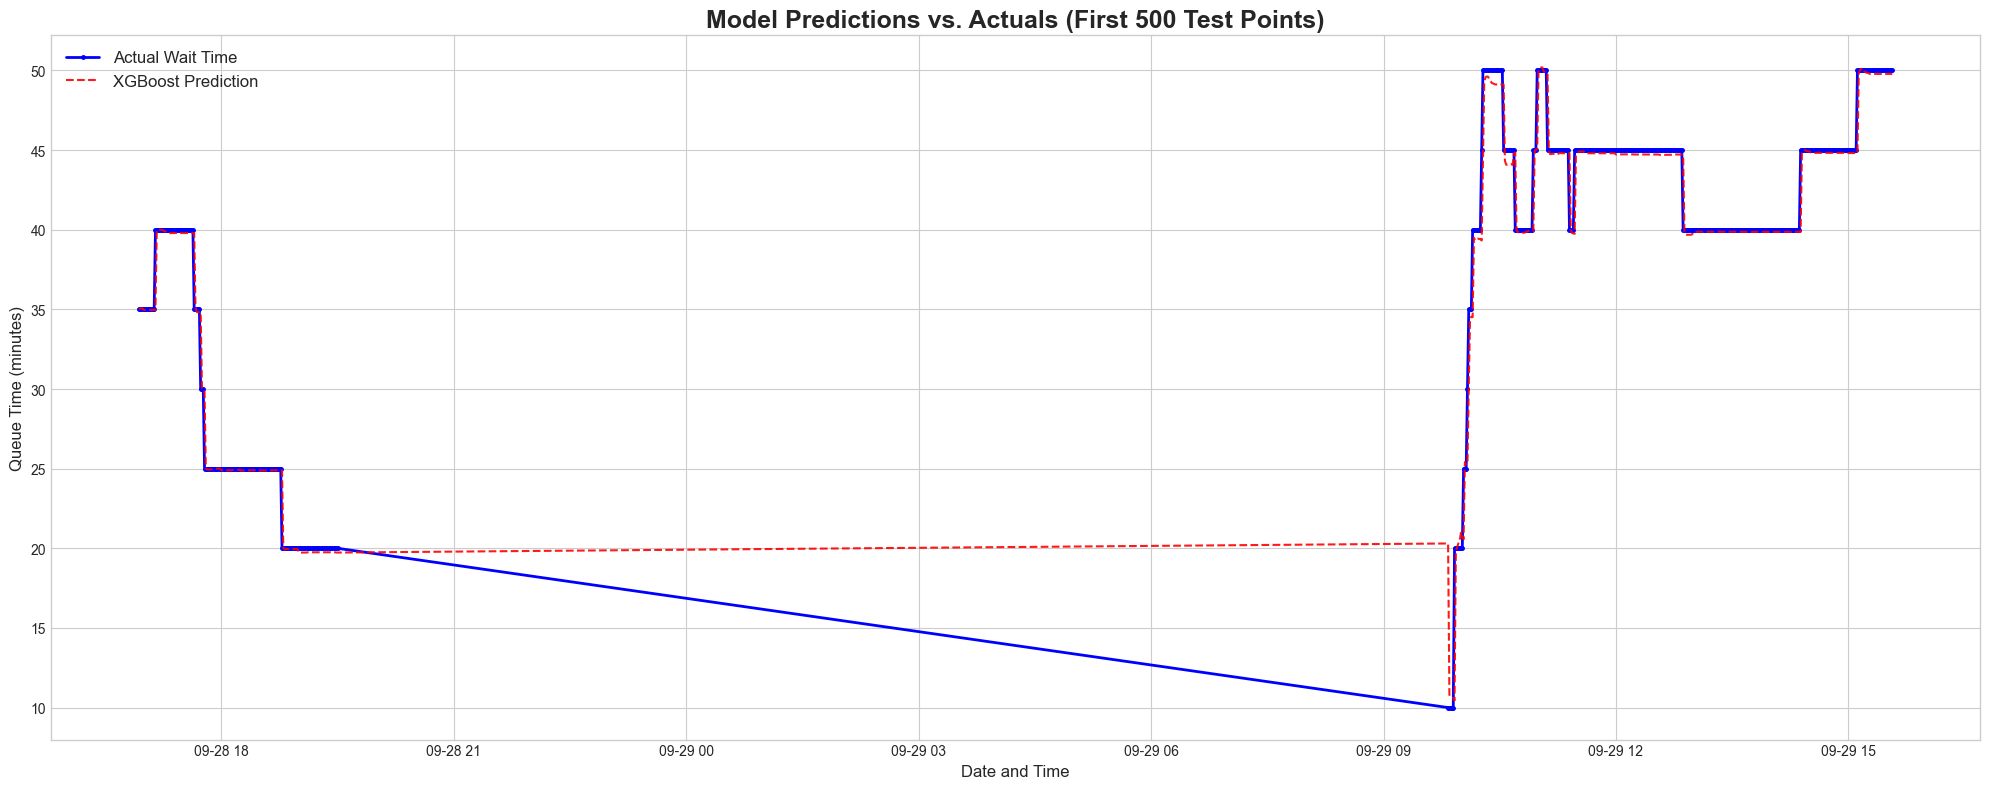

Plotting the middle 500 data points of the test set...


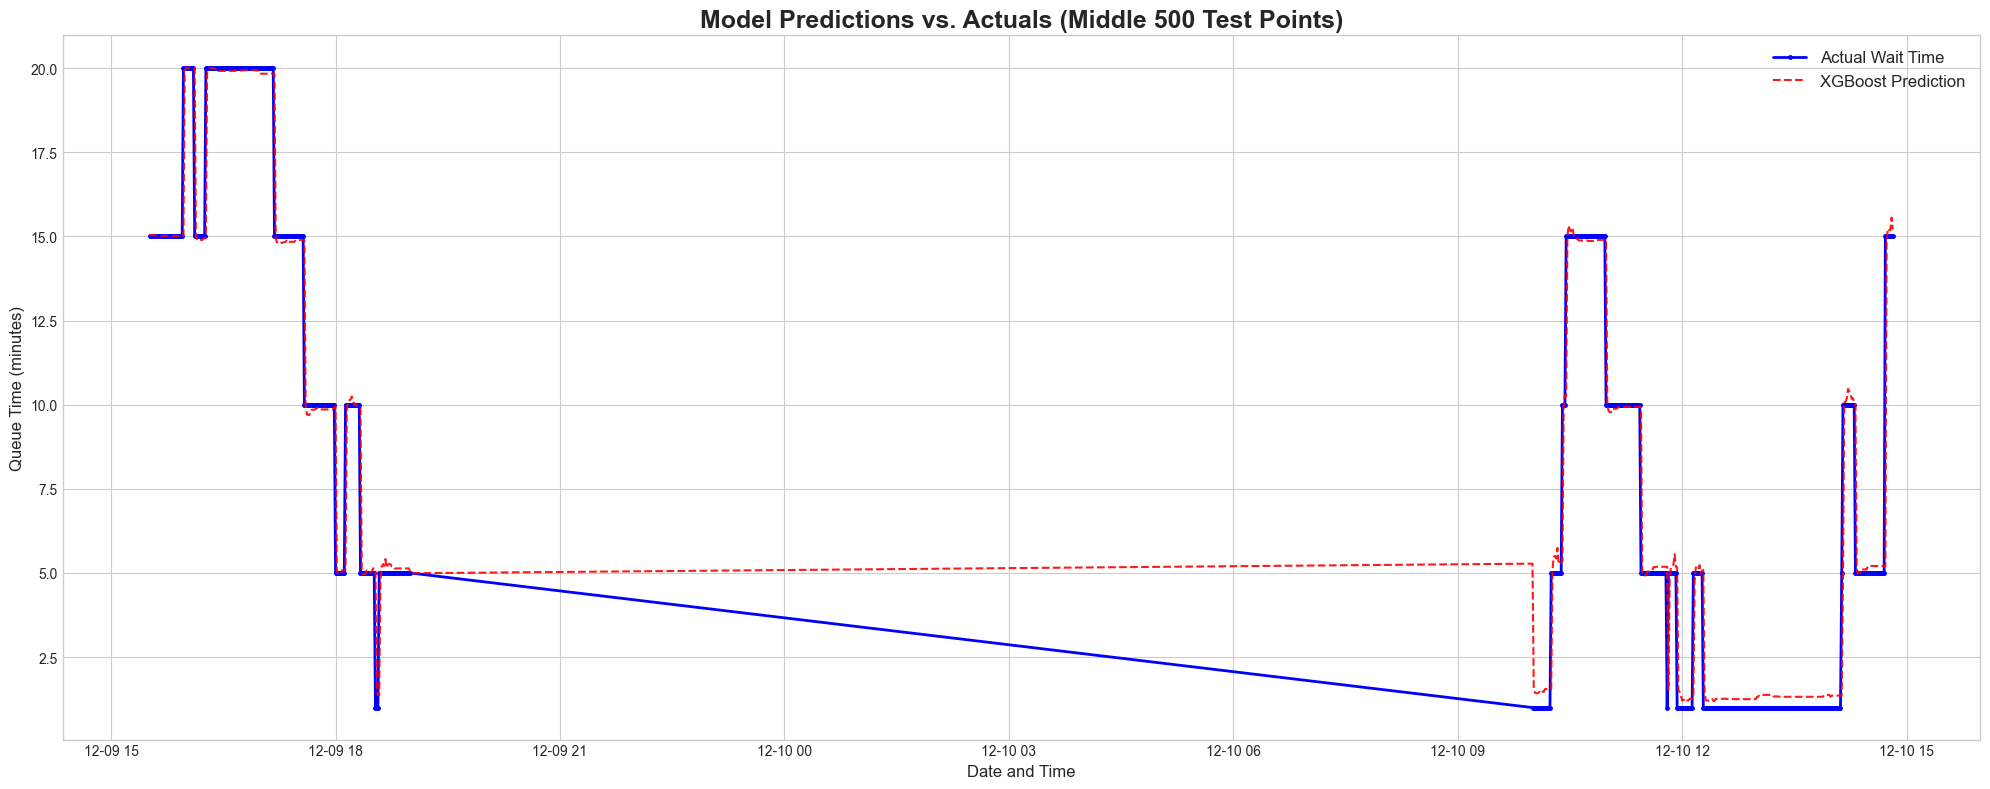

Plotting the last 500 data points of the test set...


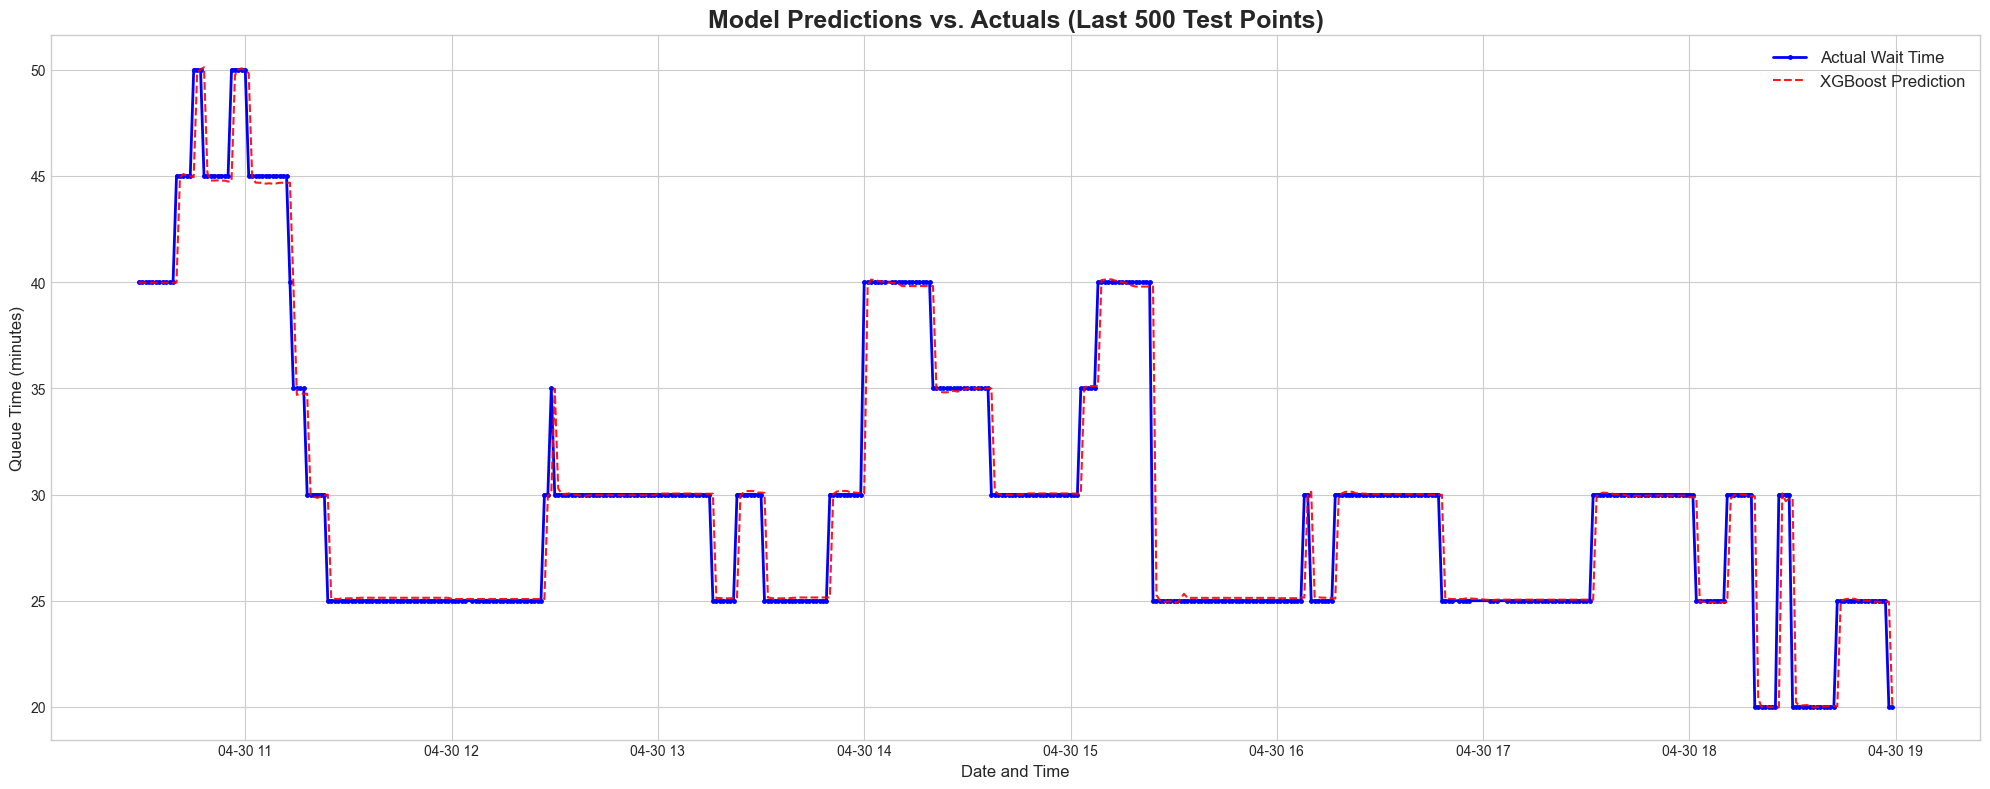

In [194]:
# Plot first, middle, and last 500 points of the test set.
#  ==========
def plot_data_slice(df_slice, title_text):
    """Plots a slice of the results DataFrame."""
    if df_slice.empty:
        print(f"Warning: The slice for '{title_text}' is empty. Skipping plot.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))
    plt.plot(df_slice['date'], df_slice['actual_wait_time'], label='Actual Wait Time', color='blue', linewidth=2, marker='.', markersize=5)
    plt.plot(df_slice['date'], df_slice['xgb_predicted_time'], label='XGBoost Prediction', color='red', linestyle='--', alpha=0.9)

    plt.title(title_text, fontsize=18, fontweight='bold')
    plt.xlabel('Date and Time', fontsize=12)
    plt.ylabel('Queue Time (minutes)', fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Define the slice size and plot
N = 500
total_test_rows = len(final_results_df)

# Plot 1: First 500 Data Points
print(f"\nPlotting the first {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[:N], f'Model Predictions vs. Actuals (First {N} Test Points)')

# Plot 2: Middle 500 Data Points
middle_point = total_test_rows // 2
start_index = middle_point - (N // 2)
end_index = middle_point + (N // 2)
print(f"Plotting the middle {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[start_index:end_index], f'Model Predictions vs. Actuals (Middle {N} Test Points)')

# Plot 3: Last 500 Data Points
print(f"Plotting the last {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[-N:], f'Model Predictions vs. Actuals (Last {N} Test Points)')


#### Performing Wilcoxon analysis

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
train_splits = np.arange(0.6, 0.80, 0.05)
results_log = []
for split_ratio in train_splits:
    print(f"\n--- Running for training split ratio: {split_ratio:.2f} ---")

    test_ratio = 1 - split_ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # XGBoost Regressor
    xgb_model = XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    lr_preds = lr_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    num_features = X_test.shape[1]

    for model_name, preds in [('Linear Regression', lr_preds), ('XGBoost', xgb_preds)]:

        # Standard metrics
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        medae = median_absolute_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        adj_r2 = adjusted_r2_score(y_test, preds, n_features=num_features)

        # Append the comprehensive dictionary of results
        results_log.append({
            'split_ratio': split_ratio,
            'model': model_name,
            'r_squared': r2,
            'adjusted_r_squared': adj_r2,
            'rmse': rmse,
            'mae': mae,
            'medae': medae,
            'mape': mape
        })
    print("\n--- Comparing models with Wilcoxon Signed-Rank Test ---")

    # 1. Calculate the absolute errors for each model's predictions
    lr_errors = np.abs(y_test - lr_preds)
    xgb_errors = np.abs(y_test - xgb_preds)

    # 2. Perform the Wilcoxon test on the paired errors
    # H0: The median of the differences between the errors is zero.
    try:
        stat, p_value = wilcoxon(lr_errors, xgb_errors)

        print(f"Wilcoxon Statistic: {stat:.4f}, P-value: {p_value:.4f}")

        # 3. Interpret the p-value
        alpha = 0.05
        if p_value < alpha:
            print("Result: The difference between model errors is statistically significant.")
        else:
            print("Result: The difference between model errors is NOT statistically significant.")

        # 4. Log the test results
        results_log.append({
            'split_ratio': split_ratio,
            'model': 'Wilcoxon Test (LR vs XGB)',
            'statistic': stat,
            'p_value': p_value
        })

    except ValueError as e:
        # This can happen if all differences are zero, which is unlikely but possible.
        print(f"Could not perform Wilcoxon test: {e}")
        results_log.append({
            'split_ratio': split_ratio,
            'model': 'Wilcoxon Test (LR vs XGB)',
            'statistic': None,
            'p_value': None,
            'error': str(e)
        })


print("\n--- Iterative training complete. ---")



--- Running for training split ratio: 0.60 ---

--- Comparing models with Wilcoxon Signed-Rank Test ---
Wilcoxon Statistic: 4578865728.0000, P-value: 0.0000
Result: The difference between model errors is statistically significant.

--- Running for training split ratio: 0.65 ---

--- Comparing models with Wilcoxon Signed-Rank Test ---
Wilcoxon Statistic: 3738398833.0000, P-value: 0.0000
Result: The difference between model errors is statistically significant.

--- Running for training split ratio: 0.70 ---

--- Comparing models with Wilcoxon Signed-Rank Test ---
Wilcoxon Statistic: 3395700198.5000, P-value: 0.0000
Result: The difference between model errors is statistically significant.

--- Running for training split ratio: 0.75 ---

--- Comparing models with Wilcoxon Signed-Rank Test ---
Wilcoxon Statistic: 2040174281.5000, P-value: 0.0000
Result: The difference between model errors is statistically significant.

--- Running for training split ratio: 0.80 ---

--- Comparing models wi

In [195]:
results_df_log.sort_values(by='mae', ascending=True)

,split_ratio,model,r_squared,adjusted_r_squared,rmse,mae,medae,mape
2,0.70,XGBoost,0.987888,0.987886,1.452070,0.548841,0.141624,1.327629e+12
1,0.65,XGBoost,0.986320,0.986317,1.474899,0.553504,0.127638,1.326502e+12
0,0.60,XGBoost,0.985339,0.985336,1.472124,0.558710,0.127636,1.055495e+12
3,0.75,XGBoost,0.986982,0.986978,1.572585,0.620083,0.142432,1.221982e+12
4,0.80,XGBoost,0.987383,0.987378,1.631290,0.663592,0.159124,1.536449e+12


Based on Wilcoxon test we decide to go with XGBRegressor with train-test split of 70/30

### Finding the best parameters for XGBRegressor model


In [ ]:


# param_grid = {
#     'max_depth': [3, 5, 7],            # Depth of the trees
#     'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
#     'n_estimators': [500, 1000],       # Number of boosting rounds (trees)
#     'subsample': [0.8, 0.9],           # Fraction of samples used for fitting the trees
#     'colsample_bytree': [0.8, 0.9],    # Fraction of features used per tree
#     'gamma': [0, 0.1]                  # Minimum loss reduction required to make a further partition
# }



# # INSTANTIATE AND CONFIGURE GridSearchCV

# xgb_model = XGBRegressor(
#         objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
#         max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
#     )
# # Instantiate GridSearchCV
# # scoring='neg_mean_squared_error': We want to minimize MSE. Scikit-learn's grid search
# # maximizes a score, so it maximizes the *negative* MSE, which is the same thing.
# # cv=5: Use 5-fold cross-validation.
# # verbose=2: Shows progress during the search.
# # n_jobs=-1: Use all available CPU cores to speed up the search.
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )


# # RUN THE SEARCH
# # This can take a significant amount of time depending on your data size and grid complexity!
# print("\n--- Starting GridSearchCV ---")
# grid_search.fit(X_train, y_train)
# print("--- GridSearchCV Complete ---")


# # REVIEW THE RESULTS
# print("\nBest parameters found: ", grid_search.best_params_)

# # The best_score_ is the average of the scores from the 5 CV folds.
# # It's negative because of the scoring choice. We make it positive.
# best_mse = -grid_search.best_score_
# best_rmse = np.sqrt(best_mse)
# print(f"Best cross-validated RMSE: {best_rmse:.4f}")


# # EVALUATE THE FINAL MODEL ON THE UNSEEN TEST SET
# print("\n--- Evaluating final model on the test set ---")
# # Get the best model found by the search
# best_model = grid_search.best_estimator_

# # Make predictions on the held-out test data
# final_preds = best_model.predict(X_test)

# # Calculate final metrics
# final_mse = mean_squared_error(y_test, final_preds)
# final_rmse = np.sqrt(final_mse)
# final_r2 = r2_score(y_test, final_preds)

# print(f"Final Test Set RMSE: {final_rmse:.4f}")
# print(f"Final Test Set R-squared: {final_r2:.4f}")


# ##### Output written here because it takes more than 2 hours to generate best parameters for XGBRegressor model

# # --- Starting GridSearchCV ---
# # Fitting 5 folds for each of 144 candidates, totalling 720 fits
# # --- GridSearchCV Complete ---

# # Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
# # Best cross-validated RMSE: 1.3058

# # --- Evaluating final model on the test set ---
# # Final Test Set RMSE: 1.2343
# # Final Test Set R-squared: 0.9925


--- Starting GridSearchCV ---
Fitting 5 folds for each of 144 candidates, totalling 720 fits
--- GridSearchCV Complete ---

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best cross-validated RMSE: 1.3058

--- Evaluating final model on the test set ---
Final Test Set RMSE: 1.2343
Final Test Set R-squared: 0.9925


### Using best parameters for XGBRegressor model


In [196]:
app_2_df = create_lagged_features(df,4,column_to_lag='arthur_waittime')

Creating 4 lagged features for column: 'arthur_waittime'


In [197]:
drop_cols = ['status_open','status_maintenance', 'status_attraction_closed', 'status_over_90_min','temperature_in_celsius', 'precipitation_in_percent','month', 'date', 'time', 'day_of_week',
       'wind_speed_in_kmh','datetime']
app_2_df = app_2_df.drop(columns=drop_cols)

In [198]:
app_2_df.head()


,arthur_waittime,year,status_virtual_queue,status_closed_weather,day,hour,week_of_year,is_weekend,arthur_waittime_lag_1,arthur_waittime_lag_2,arthur_waittime_lag_3,arthur_waittime_lag_4
99728,40.0,2022,0,0,11,9,41,0,40.0,40.0,40.0,40.0
99729,40.0,2022,0,0,11,9,41,0,40.0,40.0,40.0,40.0
99730,40.0,2022,0,0,11,9,41,0,40.0,40.0,40.0,40.0
99731,40.0,2022,0,0,11,9,41,0,40.0,40.0,40.0,40.0
99732,40.0,2022,0,0,11,9,41,0,40.0,40.0,40.0,40.0


In [199]:
y = app_2_df[target_col]
X = app_2_df.drop(columns=target_col)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)
log_result = []
# XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror', n_estimators=500, learning_rate=0.1,
    max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

xgb_preds = xgb_model.predict(X_test)
num_features = X_test.shape[1]

for model_name, preds in [('XGBoost', xgb_preds)]:

    # Standard metrics
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    medae = median_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    adj_r2 = adjusted_r2_score(y_test, preds, n_features=num_features)

    # Append the comprehensive dictionary of results
    log_result.append({
        'split_ratio': split_ratio,
        'model': model_name,
        'r_squared': r2,
        'adjusted_r_squared': adj_r2,
        'rmse': rmse,
        'mae': mae,
        'medae': medae,
        'mape': mape
    })




In [200]:
log_result_df = pd.DataFrame(log_result)

In [201]:
log_result_df

,split_ratio,model,r_squared,adjusted_r_squared,rmse,mae,medae,mape
0,0.8,XGBoost,0.990791,0.99079,1.266178,0.367259,0.088135,2.189360e+12


In [202]:
df_subset = app_1_df.loc[y_test.index]

In [203]:
df_subset.columns

Index(['arthur_waittime', 'year', 'temperature_in_celsius',
       'precipitation_in_percent', 'wind_speed_in_kmh', 'status_open',
       'status_virtual_queue', 'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10'],
      dtype='object')

In [204]:
df_subset['preds'] = preds

In [205]:
df_subset['preds_errors'] = np.abs(df_subset['preds']-df_subset['arthur_waittime'])


In [206]:
df = df_subset.copy()


In [210]:
df.columns

Index(['arthur_waittime', 'year', 'temperature_in_celsius',
       'precipitation_in_percent', 'wind_speed_in_kmh', 'status_open',
       'status_virtual_queue', 'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10', 'preds', 'preds_errors'],
      dtype='object')

### Prediction Error analysis on best XGBRegressor model


--- Summary Statistics for Prediction Errors ---
count    125496.000000
mean         -0.336756
std           9.636933
min         -42.760323
25%          -6.710995
50%          -0.054966
75%           5.941597
max          38.864162
Name: preds_errors, dtype: float64


Generating hourly error distribution plot...
Generating overall error distribution plot...
Generating actual vs. predicted plot...

Analysis complete. All plots have been saved to your directory.


<Figure size 1200x700 with 0 Axes>

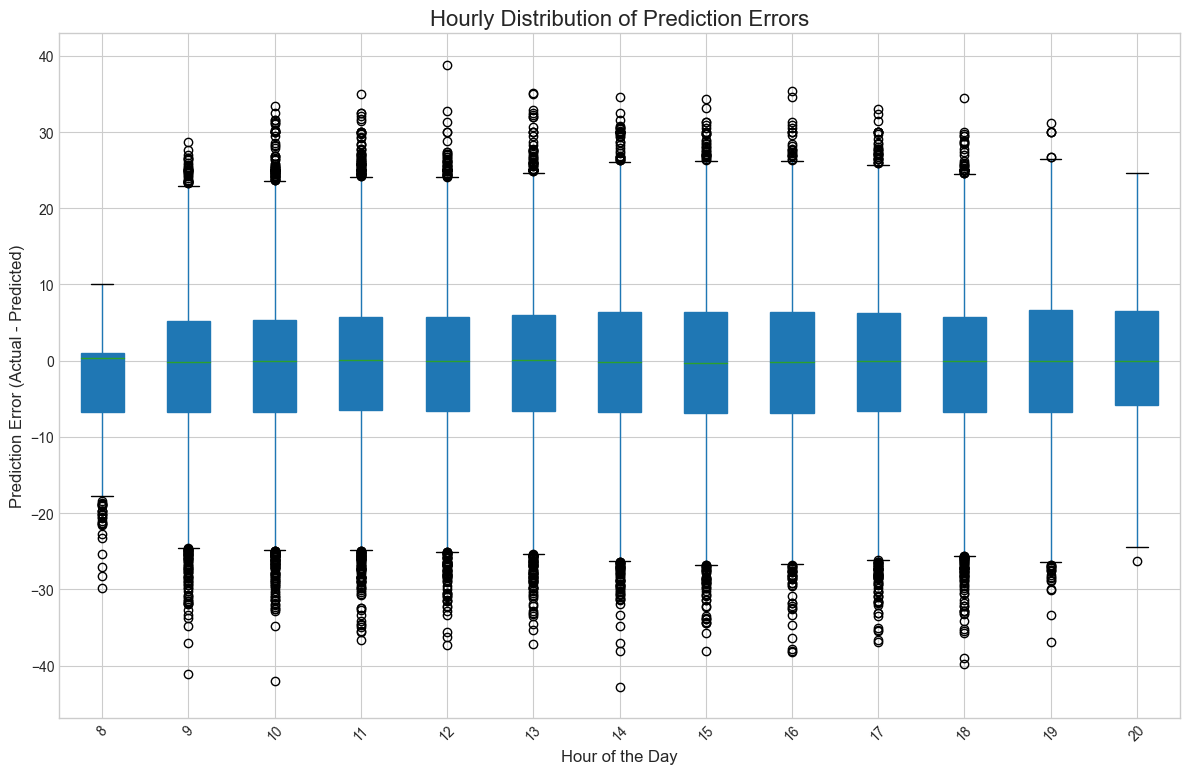

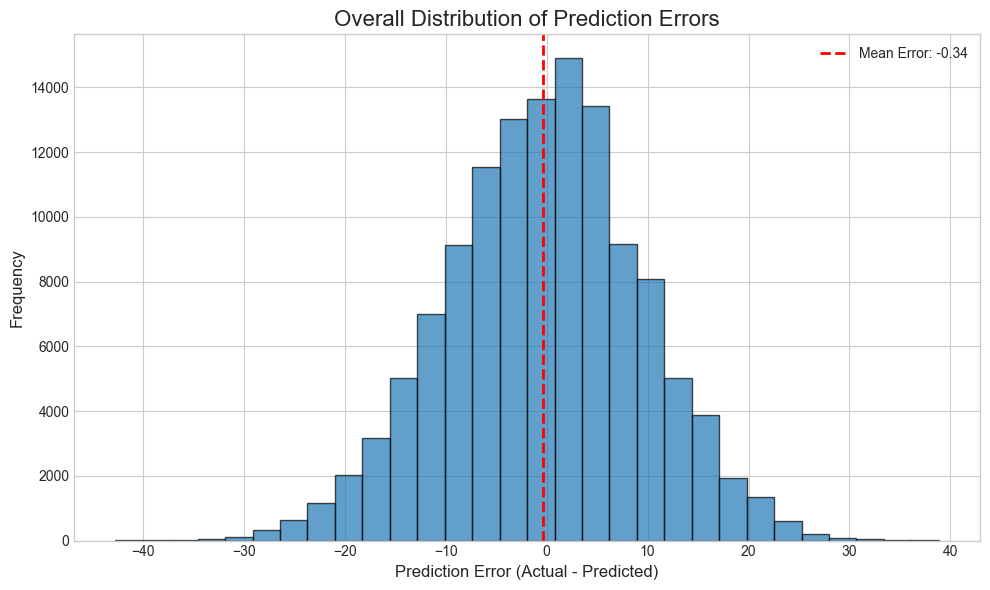

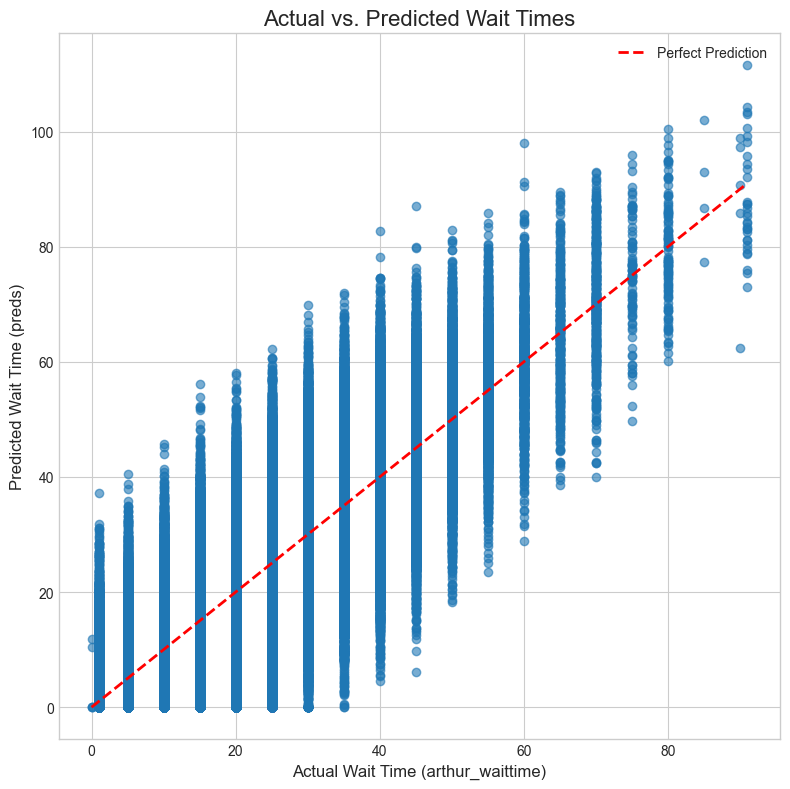

In [214]:
# Simulate predictions with some random noise
df['preds'] = df['arthur_waittime'] + np.random.normal(0, 10, size=df.shape[0])
# Ensure predictions are non-negative, as wait times cannot be negative
df['preds'] = df['preds'].clip(lower=0)

# Calculate the prediction error (actual - predicted)
df['preds_errors'] = df['arthur_waittime'] - df['preds']
# --- End of Sample Data Generation ---


# 1. Print Summary Statistics of Prediction Errors
print("--- Summary Statistics for Prediction Errors ---")
print(df['preds_errors'].describe())
print("\n" + "="*50 + "\n")


# 2. Hourly Prediction Error Analysis (Boxplot)
print("Generating hourly error distribution plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
# Use pandas built-in boxplot feature grouped by 'hour'
df.boxplot(column='preds_errors', by='hour', grid=True, patch_artist=True)
plt.title('Hourly Distribution of Prediction Errors', fontsize=16)
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.xticks(rotation=45)
# Save the figure to a file


# 3. Overall Prediction Error Range Analysis (Histogram)
print("Generating overall error distribution plot...")
plt.figure(figsize=(10, 6))
plt.hist(df['preds_errors'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Overall Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# Add a vertical line at the mean error
plt.axvline(df['preds_errors'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean Error: {df['preds_errors'].mean():.2f}")
plt.legend()
# Save the figure to a file


# 4. Scatter Plot of Predictions vs. Actuals
print("Generating actual vs. predicted plot...")
plt.figure(figsize=(8, 8))
plt.scatter(df['arthur_waittime'], df['preds'], alpha=0.6)
# Plot the "perfect prediction" line (y=x)
plt.plot(
    [df['arthur_waittime'].min(), df['arthur_waittime'].max()],
    [df['arthur_waittime'].min(), df['arthur_waittime'].max()],
    'r--', lw=2, label='Perfect Prediction'
)
plt.title('Actual vs. Predicted Wait Times', fontsize=16)
plt.xlabel('Actual Wait Time (arthur_waittime)', fontsize=12)
plt.ylabel('Predicted Wait Time (preds)', fontsize=12)
plt.legend()
# Save the figure to a file

print("\nAnalysis complete. All plots have been saved to your directory.")

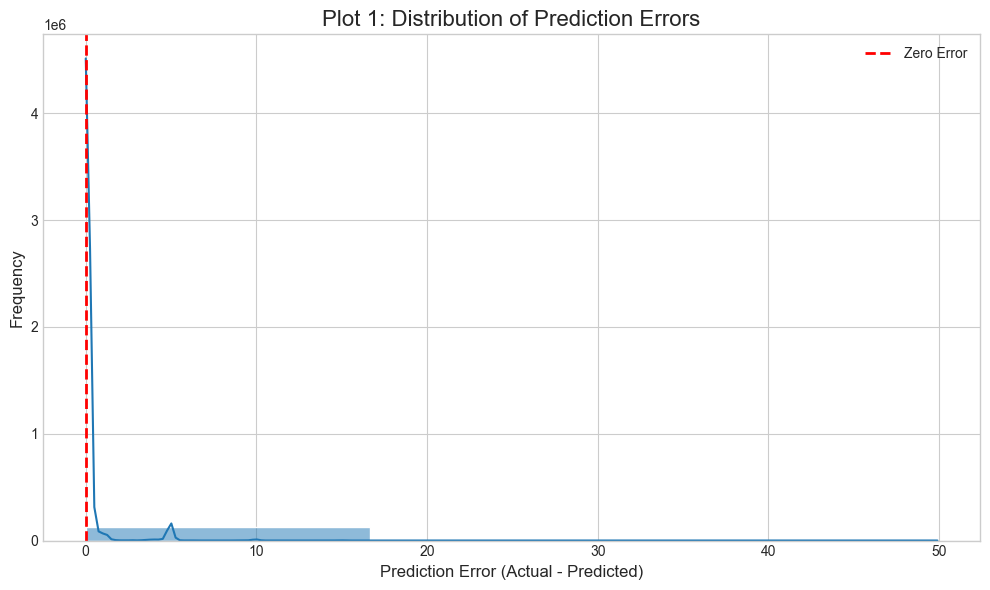

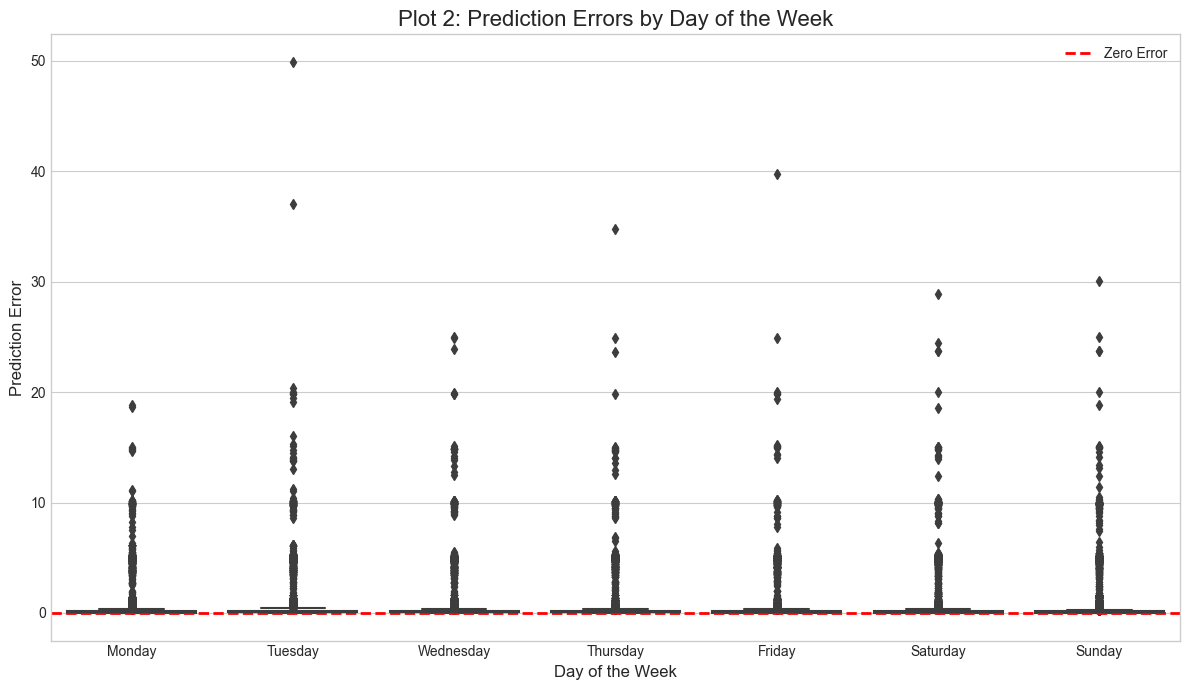

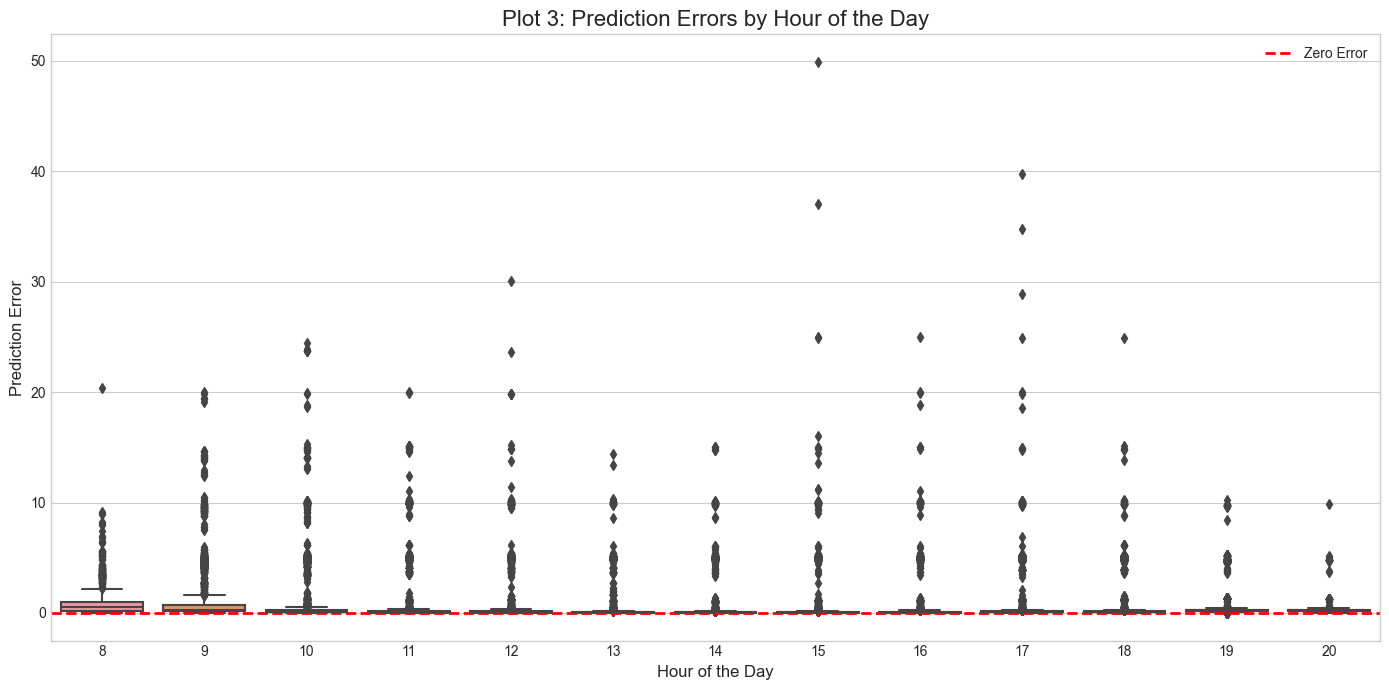

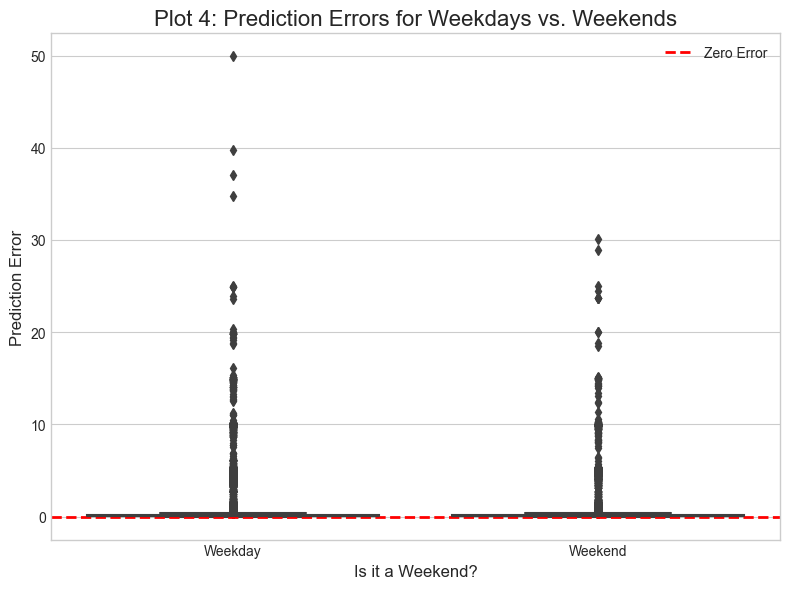

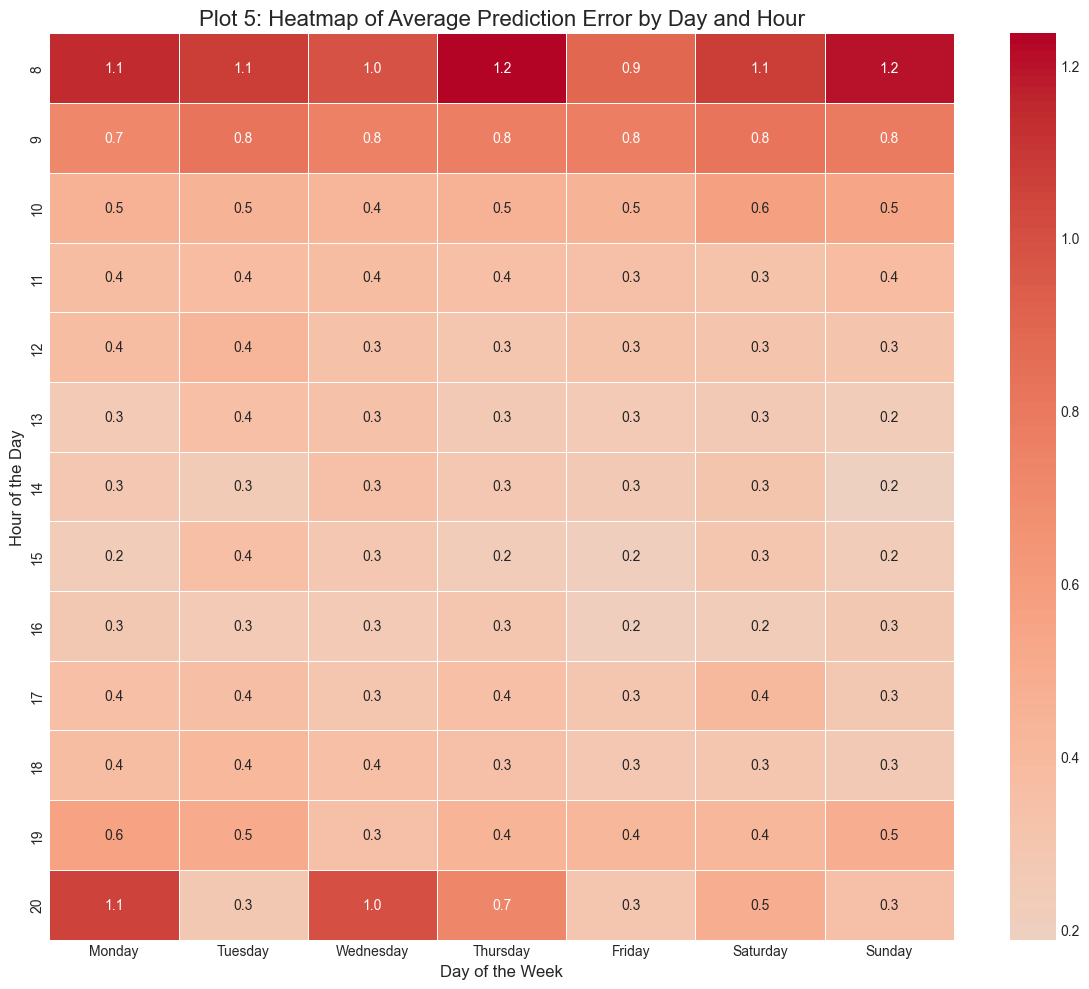

In [208]:
# --- 3. Generate Plots for Insight ---
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Plot 1: Overall Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['preds_errors'], kde=True, bins=3)
plt.title('Plot 1: Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.show()

# Plot 2: Errors by Day of the Week
# Order the days of the week for a more intuitive plot
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='day_of_week', y='preds_errors', order=day_order)
plt.title('Plot 2: Prediction Errors by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.show()


# Plot 3: Errors by Hour of the Day
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='hour', y='preds_errors')
plt.title('Plot 3: Prediction Errors by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.show()


# Plot 4: Errors by Weekend vs. Weekday
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_weekend', y='preds_errors')
plt.title('Plot 4: Prediction Errors for Weekdays vs. Weekends', fontsize=16)
plt.xlabel('Is it a Weekend?', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.show()


# Plot 5: Heatmap of Average Errors by Day and Hour
# Create a pivot table to calculate the mean error for each day-hour combination
pivot_table = df.pivot_table(values='preds_errors', index='hour', columns='day_of_week', aggfunc='mean')
# Reorder columns to follow the days of the week
pivot_table = pivot_table.reindex(columns=day_order)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5, center=0)
plt.title('Plot 5: Heatmap of Average Prediction Error by Day and Hour', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)
plt.show()

In [ ]:
y_test

,arthur_waittime
417797,35.0
417798,35.0
417799,35.0
417800,40.0
417801,40.0
...,...
534646,20.0
534647,20.0
534648,20.0
534649,20.0


In [ ]:
preds

array([34.951332, 34.951332, 34.951332, ..., 19.882952, 19.882952,
       19.882952], dtype=float32)


Percentage of predictions with errors 
hour
0     0.000000
8     0.985881
9     0.325515
10    0.239744
11    0.258878
12    0.218500
13    0.099536
14    0.072901
15    0.125794
16    0.105974
17    0.132547
18    0.106899
19    0.012900
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: count, dtype: float64


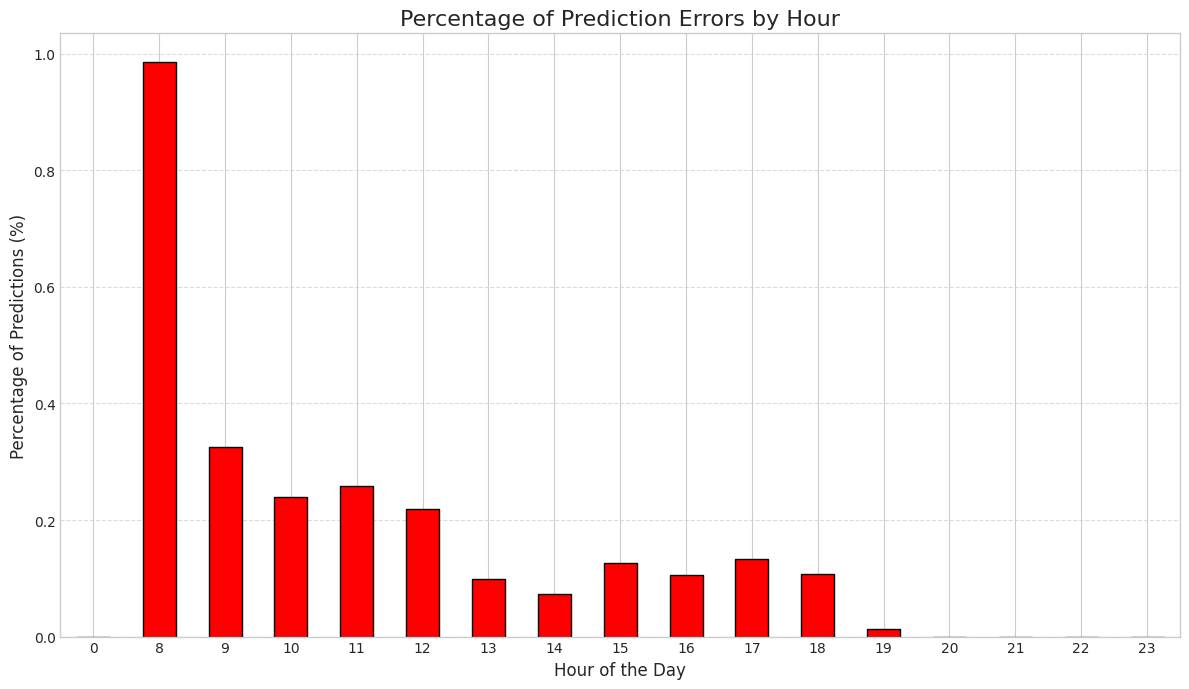

In [ ]:
total_hour_counts = df['hour'].value_counts().sort_index()

# Reindex accurate_hour_counts to align with total_hour_counts, filling missing hours with 0
aligned_accurate_counts = accurate_hour_counts.reindex(total_hour_counts.index, fill_value=0)
error_percentage_by_hour = (aligned_accurate_counts / total_hour_counts) * 100

# 7. Display the percentage result
print("\nPercentage of predictions with errors ")
print(error_percentage_by_hour)

# 8. Visualize the percentage result
plt.figure(figsize=(12, 7))
error_percentage_by_hour.plot(kind='bar', color='red', edgecolor='black')
plt.title('Percentage of Prediction Errors by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Percentage of Predictions (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [ ]:
total_hour_counts = df[df['hour']!= 8].value_counts().sort_index()

# Reindex accurate_hour_counts to align with total_hour_counts, filling missing hours with 0
aligned_accurate_counts = accurate_hour_counts.reindex(total_hour_counts.index, fill_value=0)
error_percentage_by_hour = (aligned_accurate_counts / total_hour_counts) * 100

# 7. Display the percentage result
print("\nPercentage of predictions with errors ")
print(error_percentage_by_hour)

# 8. Visualize the percentage result
plt.figure(figsize=(12, 7))
error_percentage_by_hour.plot(kind='bar', color='red', edgecolor='black')
plt.title('Percentage of Prediction Errors by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Percentage of Predictions (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


Percentage of predictions with errors 
arthur_waittime  year  temperature_in_celsius  precipitation_in_percent  wind_speed_in_kmh  status_open  status_virtual_queue  status_maintenance  status_closed_weather  status_attraction_closed  status_over_90_min  day  hour  day_of_week  week_of_year  is_weekend  arthur_waittime_lag_1  arthur_waittime_lag_2  arthur_waittime_lag_3  arthur_waittime_lag_4  arthur_waittime_lag_5  arthur_waittime_lag_6  arthur_waittime_lag_7  arthur_waittime_lag_8  arthur_waittime_lag_9  arthur_waittime_lag_10  preds      preds_errors
0.0              2024  6.1                     20.0                      15.0               1            0                     0                   0                      0                         0                   12   10    Tuesday      46            0           0.0                    1.0                    1.0                    1.0                    1.0                    1.0                    1.0                    1.0         

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7c7e48e8d760> (for post_execute):


KeyboardInterrupt: 

In [ ]:
def calculate_mae(y_true, y_pred):
    """
        Calculates the Mean Absolute Error (MAE) between true values and predictions.
    """
    # Convert to NumPy arrays for efficient element-wise operations, if not already
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Ensure the input arrays have the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Input arrays y_true and y_pred must have the same length.")

    # Handle empty inputs gracefully
    if len(y_true) == 0:
        return 0.0

    # Calculate the absolute differences
    absolute_errors = np.abs(y_true - y_pred)

    # Calculate the mean of the absolute differences
    mae = np.mean(absolute_errors)

    return mae

In [ ]:
df_with_eight = df.copy()
df_without_eight = df[df['hour'] != 8].copy()

In [ ]:
mae_without_eight = calculate_mae(df_without_eight['arthur_waittime'], df_without_eight['preds'])
mae_with_eight = calculate_mae(df_with_eight['arthur_waittime'], df_with_eight['preds'])

In [ ]:
print(f"MAE including hour 8: {mae_with_eight:.4f}")
print(f"MAE excluding hour 8: {mae_without_eight:.4f}")

MAE including hour 8: 0.3450
MAE excluding hour 8: 0.3375


In [ ]:
# --- 1. Calculate SHAP values ---
# Create an explainer object. For tree models like XGBoost, TreeExplainer is fast.
# Using shap.Explainer is a robust way as it often auto-selects the best explainer.
print("\n--- Calculating SHAP values for the test set... ---")
explainer = shap.Explainer(final_xgb_model)
shap_values = explainer(X_test)
print("--- SHAP calculation complete. ---")

# The shap_values object contains the SHAP values for every feature of every instance in X_test


--- Calculating SHAP values for the test set... ---


XGBoostError: [15:06:31] /workspace/src/c_api/c_api_utils.h:127: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (1970028 vs. 5089239) : 
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2a6ecc) [0x7c7d4e8a6ecc]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2b3387) [0x7c7d4e8b3387]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x424) [0x7c7d4e7bab04]
  [bt] (3) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7c7ef545ae2e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7c7ef5457493]
  [bt] (5) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7c7ef547f4d8]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7c7ef547ec8e]
  [bt] (7) /usr/bin/python3(_PyObject_MakeTpCall+0x27c) [0x52f85c]
  [bt] (8) /usr/bin/python3(_PyEval_EvalFrameDefault+0x6bc) [0x53da0c]



In [ ]:
# --- 2. Global Feature Importance (Beeswarm Plot) ---
print("\n--- Generating SHAP Summary Plot (Global Importance) ---")

# This plot is a rich combination of feature importance and feature effects.
# Each dot is a single prediction's SHAP value for a single feature.
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot: Global Feature Importance and Impact", fontsize=16)
plt.show()

In [ ]:
import numpy as np
global_shap=np.mean(np.abs(shap_values.values),axis=0)
import matplotlib.pyplot as plt
plt.barh(X_test.columns,global_shap)
plt.show()
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0], max_display=10)
shap.plots.waterfall(shap_values[1], max_display=10)